感情分類について初めはこちらを試しました。BERTモデルにLSTMとCNNを加えたモデルを作りました。時間的な処理と特徴抽出をして精度を高める狙いがあります。データに偏りがあるため、クラスごとの重み付け計算を行いました。今回は感情の大きさが大きいデータが少なく、データ拡張で埋めきることはできなかったこと、推論時に感情が全て0のパターンがあったことで断念しました。今回のデータセットの傾向を考えると感情が大きい文章を大量に生成して埋めることは無理だと思われます。今後は８つの感情(例：[0,0,1,1,0,0,0,0])をセットで一つのデータとして扱い、基数を計算して求まった値でラベル付けし、ラベルごとに個数が1以上になったものを文章生成で補うことで偏りを無くしたいと思います。

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
! pip install git+https://github.com/huggingface/transformers
! pip install git+https://github.com/huggingface/accelerate
! pip install datasets
! pip install fugashi ipadic
! pip install unidic-lite
#! wget https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-6gvajoqj
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-6gvajoqj
  Resolved https://github.com/huggingface/transformers to commit 5fa35344755d8d9c29610b57d175efd03776ae9e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.49.0.dev0-py3-none-any.whl size=10474239 sha256=485d668875214797813db060d19448a4c87e1d524b9a34954817481febe02618
  Stored in directory: /tmp/pip-ephem-wheel-cache-ahbzhyc2/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
  Cloning https://github.com/huggingfac

In [ ]:
#! unzip /content/drive/MyDrive/成果物3/use_model-20241228T021209Z-001.zip

Archive:  /content/drive/MyDrive/成果物3/use_model-20241228T021209Z-001.zip
  inflating: use_model/model_name__epoch001__20241227_1021.pth  


In [3]:
import pandas as pd
import numpy as np
import unidic_lite
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from datasets import Dataset
import os
import random
from transformers import BertModel, BertConfig, BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm
import datetime as dt
import matplotlib.pyplot as plt
import copy

In [4]:
emotions = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
emotion=emotions[4]

target_columns = ['Sentence'] + ['Avg. Readers_'+emotion]
%cd '/content/drive/MyDrive/成果物3/'
df_wrime_aug = pd.read_csv('wrime_sqlSimCSE_2_filtered.csv')
df_wrime = pd.read_csv('words_filtered_wrime-ver1_2.csv')
df_wrime = pd.concat([df_wrime[target_columns], df_wrime_aug[target_columns]], ignore_index=True, axis=0)
df_train, df_val = train_test_split(df_wrime, test_size=0.4, random_state=42)

# インデックスは整数のままにして値のカウントを取得
class_counts = (df_train['Avg. Readers_'+emotion].value_counts().sort_index()).astype(float)
total_samples = len(df_train)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights

/content/drive/MyDrive/成果物3


,count
Avg. Readers_Anger,
0,0.262916
1,8.604046
2,18.762605
3,37.058091


In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]='0,1,2,3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
model_name_dict = {
    "tohoku": 'tohoku-nlp/bert-base-japanese-v3',
}
class Hparams:
    def __init__(self):
        self.random_seed = 42
        self.data_dir = './data'
        self.output_dir = emotion+'bert+_norm/'
        self.batch_size = 16
        self.token_max_length = 256
        self.model_name = model_name_dict['tohoku']
        self.model_state = self.output_dir+'tohoku-nlp_bert-base-japanese-v3__epoch001__20250110_1151.pth'
        self.emotion = emotion
        self.num_epochs = 2
        self.class_weights = [class_counts.iloc[i] for i in range(4)] #実際のクラスごとのサンプル数

hps = Hparams()

def seed_torch(seed:int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(hps.random_seed)

Using cuda


In [6]:
class BertLstmCnnModel(nn.Module):
    def __init__(self, model_name=hps.model_name, use_hidden_n=10):
        super(BertLstmCnnModel, self).__init__()
        self.config = BertConfig.from_pretrained(model_name)
        self.bert = BertModel.from_pretrained(model_name, config=self.config)
        self.hidden_size = self.config.hidden_size
        self.use_hidden_n = use_hidden_n
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, batch_first=True, bidirectional=True)
        self.leakyrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.conv1d = nn.Conv1d(in_channels=self.use_hidden_n, out_channels=1, kernel_size=3, padding='same')
        self.batchnorm1d = nn.BatchNorm1d(1)
        self.classifier = nn.Linear(self.hidden_size * 2, 4)  # 4クラス分類のため、出力ノード数を4に設定

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states_list = [outputs.hidden_states[-1*i] for i in range(1, self.use_hidden_n+1)]
        self.lstm.flatten_parameters()
        out_list = [
            self.dropout(
                self.leakyrelu(
                    self.lstm(hidden_state)[0] # lstmシーケンス全体の出力(隠れ、セル状態は省く)
                )[:, -1, :] # 最後のタイムステップはシーケンス全体の文脈情報が集約されている
            ).view(-1, 1, self.hidden_size * 2)
            for hidden_state in hidden_states_list
        ]
        out = torch.cat(out_list, dim=1)
        out = self.dropout(self.leakyrelu(self.batchnorm1d(self.conv1d(out))))
        out = out.view(out.size(0), -1) # 連続性重視のためmaxpoolは未使用
        logits = self.classifier(out)
        return logits


In [7]:
def make_emotion_data(model_name, df_wrime, emotion):
    tokenizer = BertTokenizer.from_pretrained(model_name)

    # データセットの分割
    df_train, df_val = train_test_split(df_wrime, test_size=0.4, random_state=42)
    df_dev, df_test = train_test_split(df_val, test_size=0.5, random_state=42)

    target_columns = ['Sentence', 'Avg. Readers_' + emotion]
    train_dataset = Dataset.from_pandas(df_train[target_columns])
    dev_dataset = Dataset.from_pandas(df_dev[target_columns])
    test_dataset = Dataset.from_pandas(df_test[target_columns])

    def tokenize_function(batch):
        # Ensure 'Sentence' is a list of strings
        sentences = batch['Sentence']
        if not isinstance(sentences, list):
            sentences = [sentences]
        sentences = [str(s) for s in sentences]  # Convert each element to string

        tokenized_batch = tokenizer(sentences, truncation=True, padding='max_length', max_length=256)
        tokenized_batch['labels'] = batch['Avg. Readers_' + emotion]
        return tokenized_batch

    train_dataset = train_dataset.map(tokenize_function, batched=True)
    dev_dataset = dev_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)

    return train_dataset, dev_dataset, test_dataset

# データセットを作成
model_name = hps.model_name
emotion = hps.emotion
train_dataset, dev_dataset, test_dataset = make_emotion_data(model_name, df_wrime, emotion)

def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
    attention_mask = torch.stack([torch.tensor(item['attention_mask']) for item in batch])
    labels = torch.tensor([item['labels'] for item in batch], dtype=torch.long)
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Map:   0%|          | 0/35724 [00:00<?, ? examples/s]

Map:   0%|          | 0/11908 [00:00<?, ? examples/s]

Map:   0%|          | 0/11909 [00:00<?, ? examples/s]

In [8]:
class ModelCheckpoint:
    def __init__(self, save_dir: str, model_name: str):
        os.makedirs(save_dir, exist_ok=True)
        self.save_dir = save_dir
        self.model_name = model_name
        jst = dt.timezone(dt.timedelta(hours=+9), 'JST')
        dt_now = dt.datetime.now(jst)
        self.dt_now_str = dt_now.strftime('%Y%m%d_%H%M')
        self.best_loss = float('inf')
        self.best_acc = self.best_f1 = self.best_precision = self.best_recall = 0.0
        self.best_epoch = self.last_epoch = 0
        self.num_epochs = 0  # 初期化

    def get_checkpoint_name(self, epoch):
        checkpoint_name = f"{self.model_name.replace('/', '_')}__epoch{epoch:03}__{self.dt_now_str}.pth"
        checkpoint_name = os.path.join(self.save_dir, checkpoint_name)
        return checkpoint_name

    def save_checkpoint(self, model, optimizer, epoch):
        self.num_epochs = epoch + 1  # 実際のエポック数を更新
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_loss': self.best_loss,
            'best_acc': self.best_acc,
            'best_f1': self.best_f1,
            'best_precision': self.best_precision,
            'best_recall': self.best_recall,
            'best_epoch': self.best_epoch,
            'last_epoch': epoch,
            'num_epochs': self.num_epochs  # 実際のエポック数を保存
        }
        torch.save(checkpoint, self.get_checkpoint_name(epoch))

    def load_checkpoint(self, model, optimizer, manual_name=None):
        if manual_name:
            checkpoint_name = manual_name
        else:
            checkpoint_name = self.get_checkpoint_name(self.last_epoch)  # last_epochを使用してチェックポイント名を決定

        print(f"Loading checkpoint {checkpoint_name}")
        checkpoint = torch.load(checkpoint_name)

        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.best_loss = checkpoint.get('best_loss', float('inf'))
        self.best_acc = checkpoint.get('best_acc', 0.0)
        self.best_f1 = checkpoint.get('best_f1', 0.0)
        self.best_precision = checkpoint.get('best_precision', 0.0)
        self.best_recall = checkpoint.get('best_recall', 0.0)
        self.best_epoch = checkpoint.get('best_epoch', 0)
        self.last_epoch = checkpoint.get('last_epoch', 0)
        self.num_epochs = checkpoint.get('num_epochs', 0)  # num_epochsをロード

        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)

        return model, optimizer, self.last_epoch, self.best_loss, self.best_acc, self.best_f1, self.best_precision, self.best_recall, self.num_epochs


In [9]:
def initialize_model_and_optimizer(checkpoint_path, model_name, device):
    model = BertLstmCnnModel(model_name=model_name)
    model.to(device)

    optimizer = torch.optim.AdamW(
        params=[
            {'params': model.bert.embeddings.parameters(), 'lr': 1e-5},
            {'params': model.bert.encoder.parameters(), 'lr': 3e-5},
            {'params': model.bert.pooler.parameters(), 'lr': 5e-5},
            {'params': model.lstm.parameters(), 'lr': 5e-4},
            {'params': model.conv1d.parameters(), 'lr': 5e-4},
            {'params': model.classifier.parameters(), 'lr': 1e-3}
        ]
    )

    checkpoint = ModelCheckpoint(save_dir=hps.output_dir, model_name=model_name)

    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, best_loss, best_acc, best_f1, best_precision, best_recall, past_epochs = checkpoint.load_checkpoint(model, optimizer, manual_name=checkpoint_path)
        print(f"Resuming training from epoch {start_epoch + 1}")
        new_epochs = hps.num_epochs
        total_epochs = past_epochs + new_epochs  # 過去のエポック数に新しいエポック数を加算
    else:
        start_epoch = 0
        best_loss = float('inf')
        best_acc = best_f1 = best_precision = best_recall = 0.0
        new_epochs = hps.num_epochs  # 新しいトレーニングのための初期設定
        past_epochs = 0  # 新しいトレーニングセッション
        total_epochs = new_epochs
        print("Starting new training")

    return model, optimizer, start_epoch, best_loss, best_acc, best_f1, best_precision, best_recall, past_epochs, new_epochs, total_epochs, checkpoint


def fit(dataloaders, model, optimizer, past_epochs, new_epochs, batch_size, scheduler, class_weights_tensor, start_epoch=0, checkpoint=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    history = {
        'train': {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': []},
        'val': {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': []},
        'lr': [],
    }

    best_model_wts = copy.deepcopy(model.state_dict())

    print(f"使用デバイス : {device}")
    total_epochs = past_epochs + new_epochs
    for epoch in range(start_epoch, start_epoch + new_epochs):  # 新しいトレーニング回数だけ実行
        print(f"【Epoch {epoch+1: 3}/{total_epochs: 3}】   LR -> ", end='')
        for i, params in enumerate(optimizer.param_groups):
            print(f"Group{i}: {params['lr']:.4e}", end=' / ')
        print('')

        for phase in ['train', 'val']:
            running_loss = 0.0
            running_corrects = 0
            preds_labels_dict = {'preds': [], 'labels': []}

            if phase == 'train':
                model.train()
            else:
                model.eval()

            for i, batch in enumerate(tqdm(dataloaders[phase], desc=f"{phase} Epoch {epoch+1}", leave=False)):
                inputs = batch
                labels = batch['labels']
                input_ids = inputs['input_ids']
                attention_mask = inputs['attention_mask']
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    logits_outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
                    loss = criterion(logits_outputs, labels)

                    _, preds = torch.max(logits_outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                running_loss += loss.item() * input_ids.size(0)
                running_corrects += torch.sum(preds == labels)
                preds_labels_dict['preds'].extend(preds.cpu().numpy())
                preds_labels_dict['labels'].extend(labels.cpu().numpy())

                # 20ステップごとに結果を表示
                if phase == 'train' and i % 20 == 19:
                    total_num = float((i * batch_size) + input_ids.size(0))
                    print(f"{i+1: 4}/{len(dataloaders[phase]): 4}  <{phase}> Loss: {(running_loss/total_num):.4f}  Acc: {(running_corrects/total_num):.4f}  LR -> ", end='')
                    for j, params in enumerate(optimizer.param_groups):
                        print(f"Group{j}: {params['lr']:.4e}", end=' / ')
                        if isinstance(optimizer.param_groups[0]['lr'], float):
                            history['lr'].append(optimizer.param_groups[0]['lr'])
                    print('\n')

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(preds_labels_dict['labels'], preds_labels_dict['preds'], average='weighted')
            epoch_precision = precision_score(preds_labels_dict['labels'], preds_labels_dict['preds'], average='weighted')
            epoch_recall = recall_score(preds_labels_dict['labels'], preds_labels_dict['preds'], average='weighted')

            print(f"<{phase}> Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}  F1: {epoch_f1:.4f}  Precision: {epoch_precision:.4f}  Recall: {epoch_recall:.4f}\n")

            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc.item())
            history[phase]['f1'].append(epoch_f1)
            history[phase]['precision'].append(epoch_precision)
            history[phase]['recall'].append(epoch_recall)

            if phase == 'val' and epoch_f1 > checkpoint.best_f1:
                checkpoint.best_loss = epoch_loss
                checkpoint.best_acc = epoch_acc
                checkpoint.best_f1 = epoch_f1
                checkpoint.best_precision = epoch_precision
                checkpoint.best_recall = epoch_recall
                checkpoint.best_epoch = epoch + 1
                best_model_wts = copy.deepcopy(model.state_dict())

        checkpoint.num_epochs = past_epochs + (epoch - start_epoch + 1)  # 実際のトレーニング回数を更新
        checkpoint.save_checkpoint(model, optimizer, epoch)
        print('-' * 150)
    model.load_state_dict(best_model_wts)
    torch.cuda.empty_cache()
    return model, history


config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/447M [00:00<?, ?B/s]

Starting new training
/content/drive/MyDrive/成果物3
使用デバイス : cuda
【Epoch   1/  2】   LR -> Group0: 1.0000e-05 / Group1: 3.0000e-05 / Group2: 5.0000e-05 / Group3: 5.0000e-04 / Group4: 5.0000e-04 / Group5: 1.0000e-03 / 


train Epoch 1:   0%|          | 0/2233 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/447M [00:00<?, ?B/s]

train Epoch 1:   1%|          | 20/2233 [00:40<1:11:28,  1.94s/it]

  20/ 2233  <train> Loss: 0.0936  Acc: 0.9156  LR -> Group0: 9.9552e-06 / Group1: 2.9866e-05 / Group2: 4.9776e-05 / Group3: 4.9776e-04 / Group4: 4.9776e-04 / Group5: 9.9552e-04 / 



train Epoch 1:   2%|▏         | 40/2233 [01:21<1:17:53,  2.13s/it]

  40/ 2233  <train> Loss: 0.0565  Acc: 0.9234  LR -> Group0: 9.9104e-06 / Group1: 2.9731e-05 / Group2: 4.9552e-05 / Group3: 4.9552e-04 / Group4: 4.9552e-04 / Group5: 9.9104e-04 / 



train Epoch 1:   3%|▎         | 60/2233 [02:03<1:14:10,  2.05s/it]

  60/ 2233  <train> Loss: 0.0413  Acc: 0.9323  LR -> Group0: 9.8657e-06 / Group1: 2.9597e-05 / Group2: 4.9328e-05 / Group3: 4.9328e-04 / Group4: 4.9328e-04 / Group5: 9.8657e-04 / 



train Epoch 1:   4%|▎         | 80/2233 [02:44<1:14:58,  2.09s/it]

  80/ 2233  <train> Loss: 0.0332  Acc: 0.9375  LR -> Group0: 9.8209e-06 / Group1: 2.9463e-05 / Group2: 4.9104e-05 / Group3: 4.9104e-04 / Group4: 4.9104e-04 / Group5: 9.8209e-04 / 



train Epoch 1:   4%|▍         | 100/2233 [03:26<1:13:41,  2.07s/it]

 100/ 2233  <train> Loss: 0.0282  Acc: 0.9419  LR -> Group0: 9.7761e-06 / Group1: 2.9328e-05 / Group2: 4.8880e-05 / Group3: 4.8880e-04 / Group4: 4.8880e-04 / Group5: 9.7761e-04 / 



train Epoch 1:   5%|▌         | 120/2233 [04:07<1:12:57,  2.07s/it]

 120/ 2233  <train> Loss: 0.0254  Acc: 0.9432  LR -> Group0: 9.7313e-06 / Group1: 2.9194e-05 / Group2: 4.8657e-05 / Group3: 4.8657e-04 / Group4: 4.8657e-04 / Group5: 9.7313e-04 / 



train Epoch 1:   6%|▋         | 140/2233 [04:49<1:12:49,  2.09s/it]

 140/ 2233  <train> Loss: 0.0236  Acc: 0.9420  LR -> Group0: 9.6865e-06 / Group1: 2.9060e-05 / Group2: 4.8433e-05 / Group3: 4.8433e-04 / Group4: 4.8433e-04 / Group5: 9.6865e-04 / 



train Epoch 1:   7%|▋         | 160/2233 [05:30<1:11:30,  2.07s/it]

 160/ 2233  <train> Loss: 0.0230  Acc: 0.9391  LR -> Group0: 9.6417e-06 / Group1: 2.8925e-05 / Group2: 4.8209e-05 / Group3: 4.8209e-04 / Group4: 4.8209e-04 / Group5: 9.6417e-04 / 



train Epoch 1:   8%|▊         | 180/2233 [06:12<1:10:57,  2.07s/it]

 180/ 2233  <train> Loss: 0.0218  Acc: 0.9396  LR -> Group0: 9.5970e-06 / Group1: 2.8791e-05 / Group2: 4.7985e-05 / Group3: 4.7985e-04 / Group4: 4.7985e-04 / Group5: 9.5970e-04 / 



train Epoch 1:   9%|▉         | 200/2233 [06:53<1:10:28,  2.08s/it]

 200/ 2233  <train> Loss: 0.0208  Acc: 0.9403  LR -> Group0: 9.5522e-06 / Group1: 2.8657e-05 / Group2: 4.7761e-05 / Group3: 4.7761e-04 / Group4: 4.7761e-04 / Group5: 9.5522e-04 / 



train Epoch 1:  10%|▉         | 220/2233 [07:35<1:09:59,  2.09s/it]

 220/ 2233  <train> Loss: 0.0201  Acc: 0.9403  LR -> Group0: 9.5074e-06 / Group1: 2.8522e-05 / Group2: 4.7537e-05 / Group3: 4.7537e-04 / Group4: 4.7537e-04 / Group5: 9.5074e-04 / 



train Epoch 1:  11%|█         | 240/2233 [08:16<1:08:45,  2.07s/it]

 240/ 2233  <train> Loss: 0.0194  Acc: 0.9409  LR -> Group0: 9.4626e-06 / Group1: 2.8388e-05 / Group2: 4.7313e-05 / Group3: 4.7313e-04 / Group4: 4.7313e-04 / Group5: 9.4626e-04 / 



train Epoch 1:  12%|█▏        | 260/2233 [08:58<1:08:46,  2.09s/it]

 260/ 2233  <train> Loss: 0.0184  Acc: 0.9428  LR -> Group0: 9.4178e-06 / Group1: 2.8253e-05 / Group2: 4.7089e-05 / Group3: 4.7089e-04 / Group4: 4.7089e-04 / Group5: 9.4178e-04 / 



train Epoch 1:  13%|█▎        | 280/2233 [09:40<1:07:28,  2.07s/it]

 280/ 2233  <train> Loss: 0.0180  Acc: 0.9431  LR -> Group0: 9.3730e-06 / Group1: 2.8119e-05 / Group2: 4.6865e-05 / Group3: 4.6865e-04 / Group4: 4.6865e-04 / Group5: 9.3730e-04 / 



train Epoch 1:  13%|█▎        | 300/2233 [10:21<1:07:32,  2.10s/it]

 300/ 2233  <train> Loss: 0.0174  Acc: 0.9444  LR -> Group0: 9.3283e-06 / Group1: 2.7985e-05 / Group2: 4.6641e-05 / Group3: 4.6641e-04 / Group4: 4.6641e-04 / Group5: 9.3283e-04 / 



train Epoch 1:  14%|█▍        | 320/2233 [11:03<1:06:04,  2.07s/it]

 320/ 2233  <train> Loss: 0.0168  Acc: 0.9455  LR -> Group0: 9.2835e-06 / Group1: 2.7850e-05 / Group2: 4.6417e-05 / Group3: 4.6417e-04 / Group4: 4.6417e-04 / Group5: 9.2835e-04 / 



train Epoch 1:  15%|█▌        | 340/2233 [11:44<1:05:43,  2.08s/it]

 340/ 2233  <train> Loss: 0.0168  Acc: 0.9445  LR -> Group0: 9.2387e-06 / Group1: 2.7716e-05 / Group2: 4.6193e-05 / Group3: 4.6193e-04 / Group4: 4.6193e-04 / Group5: 9.2387e-04 / 



train Epoch 1:  16%|█▌        | 360/2233 [12:26<1:04:32,  2.07s/it]

 360/ 2233  <train> Loss: 0.0164  Acc: 0.9451  LR -> Group0: 9.1939e-06 / Group1: 2.7582e-05 / Group2: 4.5970e-05 / Group3: 4.5970e-04 / Group4: 4.5970e-04 / Group5: 9.1939e-04 / 



train Epoch 1:  17%|█▋        | 380/2233 [13:08<1:05:09,  2.11s/it]

 380/ 2233  <train> Loss: 0.0160  Acc: 0.9457  LR -> Group0: 9.1491e-06 / Group1: 2.7447e-05 / Group2: 4.5746e-05 / Group3: 4.5746e-04 / Group4: 4.5746e-04 / Group5: 9.1491e-04 / 



train Epoch 1:  18%|█▊        | 400/2233 [13:49<1:03:14,  2.07s/it]

 400/ 2233  <train> Loss: 0.0155  Acc: 0.9469  LR -> Group0: 9.1043e-06 / Group1: 2.7313e-05 / Group2: 4.5522e-05 / Group3: 4.5522e-04 / Group4: 4.5522e-04 / Group5: 9.1043e-04 / 



train Epoch 1:  19%|█▉        | 420/2233 [14:31<1:02:51,  2.08s/it]

 420/ 2233  <train> Loss: 0.0151  Acc: 0.9479  LR -> Group0: 9.0596e-06 / Group1: 2.7179e-05 / Group2: 4.5298e-05 / Group3: 4.5298e-04 / Group4: 4.5298e-04 / Group5: 9.0596e-04 / 



train Epoch 1:  20%|█▉        | 440/2233 [15:13<1:02:19,  2.09s/it]

 440/ 2233  <train> Loss: 0.0149  Acc: 0.9480  LR -> Group0: 9.0148e-06 / Group1: 2.7044e-05 / Group2: 4.5074e-05 / Group3: 4.5074e-04 / Group4: 4.5074e-04 / Group5: 9.0148e-04 / 



train Epoch 1:  21%|██        | 460/2233 [15:54<1:01:17,  2.07s/it]

 460/ 2233  <train> Loss: 0.0147  Acc: 0.9481  LR -> Group0: 8.9700e-06 / Group1: 2.6910e-05 / Group2: 4.4850e-05 / Group3: 4.4850e-04 / Group4: 4.4850e-04 / Group5: 8.9700e-04 / 



train Epoch 1:  21%|██▏       | 480/2233 [16:36<1:00:56,  2.09s/it]

 480/ 2233  <train> Loss: 0.0145  Acc: 0.9480  LR -> Group0: 8.9252e-06 / Group1: 2.6776e-05 / Group2: 4.4626e-05 / Group3: 4.4626e-04 / Group4: 4.4626e-04 / Group5: 8.9252e-04 / 



train Epoch 1:  22%|██▏       | 500/2233 [17:17<1:00:03,  2.08s/it]

 500/ 2233  <train> Loss: 0.0142  Acc: 0.9489  LR -> Group0: 8.8804e-06 / Group1: 2.6641e-05 / Group2: 4.4402e-05 / Group3: 4.4402e-04 / Group4: 4.4402e-04 / Group5: 8.8804e-04 / 



train Epoch 1:  23%|██▎       | 520/2233 [17:59<59:30,  2.08s/it]

 520/ 2233  <train> Loss: 0.0139  Acc: 0.9493  LR -> Group0: 8.8356e-06 / Group1: 2.6507e-05 / Group2: 4.4178e-05 / Group3: 4.4178e-04 / Group4: 4.4178e-04 / Group5: 8.8356e-04 / 



train Epoch 1:  24%|██▍       | 540/2233 [18:40<58:40,  2.08s/it]

 540/ 2233  <train> Loss: 0.0137  Acc: 0.9500  LR -> Group0: 8.7909e-06 / Group1: 2.6373e-05 / Group2: 4.3954e-05 / Group3: 4.3954e-04 / Group4: 4.3954e-04 / Group5: 8.7909e-04 / 



train Epoch 1:  25%|██▌       | 560/2233 [19:22<57:53,  2.08s/it]

 560/ 2233  <train> Loss: 0.0136  Acc: 0.9500  LR -> Group0: 8.7461e-06 / Group1: 2.6238e-05 / Group2: 4.3730e-05 / Group3: 4.3730e-04 / Group4: 4.3730e-04 / Group5: 8.7461e-04 / 



train Epoch 1:  26%|██▌       | 580/2233 [20:03<57:07,  2.07s/it]

 580/ 2233  <train> Loss: 0.0135  Acc: 0.9497  LR -> Group0: 8.7013e-06 / Group1: 2.6104e-05 / Group2: 4.3506e-05 / Group3: 4.3506e-04 / Group4: 4.3506e-04 / Group5: 8.7013e-04 / 



train Epoch 1:  27%|██▋       | 600/2233 [20:45<56:41,  2.08s/it]

 600/ 2233  <train> Loss: 0.0135  Acc: 0.9493  LR -> Group0: 8.6565e-06 / Group1: 2.5970e-05 / Group2: 4.3283e-05 / Group3: 4.3283e-04 / Group4: 4.3283e-04 / Group5: 8.6565e-04 / 



train Epoch 1:  28%|██▊       | 620/2233 [21:27<55:46,  2.07s/it]

 620/ 2233  <train> Loss: 0.0134  Acc: 0.9492  LR -> Group0: 8.6117e-06 / Group1: 2.5835e-05 / Group2: 4.3059e-05 / Group3: 4.3059e-04 / Group4: 4.3059e-04 / Group5: 8.6117e-04 / 



train Epoch 1:  29%|██▊       | 640/2233 [22:08<54:55,  2.07s/it]

 640/ 2233  <train> Loss: 0.0133  Acc: 0.9491  LR -> Group0: 8.5670e-06 / Group1: 2.5701e-05 / Group2: 4.2835e-05 / Group3: 4.2835e-04 / Group4: 4.2835e-04 / Group5: 8.5670e-04 / 



train Epoch 1:  30%|██▉       | 660/2233 [22:49<54:25,  2.08s/it]

 660/ 2233  <train> Loss: 0.0133  Acc: 0.9490  LR -> Group0: 8.5222e-06 / Group1: 2.5567e-05 / Group2: 4.2611e-05 / Group3: 4.2611e-04 / Group4: 4.2611e-04 / Group5: 8.5222e-04 / 



train Epoch 1:  30%|███       | 680/2233 [23:31<54:08,  2.09s/it]

 680/ 2233  <train> Loss: 0.0131  Acc: 0.9495  LR -> Group0: 8.4774e-06 / Group1: 2.5432e-05 / Group2: 4.2387e-05 / Group3: 4.2387e-04 / Group4: 4.2387e-04 / Group5: 8.4774e-04 / 



train Epoch 1:  31%|███▏      | 700/2233 [24:13<52:47,  2.07s/it]

 700/ 2233  <train> Loss: 0.0130  Acc: 0.9497  LR -> Group0: 8.4326e-06 / Group1: 2.5298e-05 / Group2: 4.2163e-05 / Group3: 4.2163e-04 / Group4: 4.2163e-04 / Group5: 8.4326e-04 / 



train Epoch 1:  32%|███▏      | 720/2233 [24:54<52:21,  2.08s/it]

 720/ 2233  <train> Loss: 0.0129  Acc: 0.9501  LR -> Group0: 8.3878e-06 / Group1: 2.5163e-05 / Group2: 4.1939e-05 / Group3: 4.1939e-04 / Group4: 4.1939e-04 / Group5: 8.3878e-04 / 



train Epoch 1:  33%|███▎      | 740/2233 [25:36<51:52,  2.08s/it]

 740/ 2233  <train> Loss: 0.0127  Acc: 0.9506  LR -> Group0: 8.3430e-06 / Group1: 2.5029e-05 / Group2: 4.1715e-05 / Group3: 4.1715e-04 / Group4: 4.1715e-04 / Group5: 8.3430e-04 / 



train Epoch 1:  34%|███▍      | 760/2233 [26:17<50:37,  2.06s/it]

 760/ 2233  <train> Loss: 0.0126  Acc: 0.9507  LR -> Group0: 8.2983e-06 / Group1: 2.4895e-05 / Group2: 4.1491e-05 / Group3: 4.1491e-04 / Group4: 4.1491e-04 / Group5: 8.2983e-04 / 



train Epoch 1:  35%|███▍      | 780/2233 [26:59<50:37,  2.09s/it]

 780/ 2233  <train> Loss: 0.0124  Acc: 0.9513  LR -> Group0: 8.2535e-06 / Group1: 2.4760e-05 / Group2: 4.1267e-05 / Group3: 4.1267e-04 / Group4: 4.1267e-04 / Group5: 8.2535e-04 / 



train Epoch 1:  36%|███▌      | 800/2233 [27:40<49:16,  2.06s/it]

 800/ 2233  <train> Loss: 0.0123  Acc: 0.9516  LR -> Group0: 8.2087e-06 / Group1: 2.4626e-05 / Group2: 4.1043e-05 / Group3: 4.1043e-04 / Group4: 4.1043e-04 / Group5: 8.2087e-04 / 



train Epoch 1:  37%|███▋      | 820/2233 [28:22<49:07,  2.09s/it]

 820/ 2233  <train> Loss: 0.0124  Acc: 0.9513  LR -> Group0: 8.1639e-06 / Group1: 2.4492e-05 / Group2: 4.0820e-05 / Group3: 4.0820e-04 / Group4: 4.0820e-04 / Group5: 8.1639e-04 / 



train Epoch 1:  38%|███▊      | 840/2233 [29:04<48:30,  2.09s/it]

 840/ 2233  <train> Loss: 0.0124  Acc: 0.9509  LR -> Group0: 8.1191e-06 / Group1: 2.4357e-05 / Group2: 4.0596e-05 / Group3: 4.0596e-04 / Group4: 4.0596e-04 / Group5: 8.1191e-04 / 



train Epoch 1:  39%|███▊      | 860/2233 [29:45<47:24,  2.07s/it]

 860/ 2233  <train> Loss: 0.0122  Acc: 0.9515  LR -> Group0: 8.0743e-06 / Group1: 2.4223e-05 / Group2: 4.0372e-05 / Group3: 4.0372e-04 / Group4: 4.0372e-04 / Group5: 8.0743e-04 / 



train Epoch 1:  39%|███▉      | 880/2233 [30:27<47:00,  2.08s/it]

 880/ 2233  <train> Loss: 0.0121  Acc: 0.9516  LR -> Group0: 8.0296e-06 / Group1: 2.4089e-05 / Group2: 4.0148e-05 / Group3: 4.0148e-04 / Group4: 4.0148e-04 / Group5: 8.0296e-04 / 



train Epoch 1:  40%|████      | 900/2233 [31:08<46:21,  2.09s/it]

 900/ 2233  <train> Loss: 0.0120  Acc: 0.9513  LR -> Group0: 7.9848e-06 / Group1: 2.3954e-05 / Group2: 3.9924e-05 / Group3: 3.9924e-04 / Group4: 3.9924e-04 / Group5: 7.9848e-04 / 



train Epoch 1:  41%|████      | 920/2233 [31:50<45:16,  2.07s/it]

 920/ 2233  <train> Loss: 0.0120  Acc: 0.9514  LR -> Group0: 7.9400e-06 / Group1: 2.3820e-05 / Group2: 3.9700e-05 / Group3: 3.9700e-04 / Group4: 3.9700e-04 / Group5: 7.9400e-04 / 



train Epoch 1:  42%|████▏     | 940/2233 [32:31<45:15,  2.10s/it]

 940/ 2233  <train> Loss: 0.0120  Acc: 0.9511  LR -> Group0: 7.8952e-06 / Group1: 2.3686e-05 / Group2: 3.9476e-05 / Group3: 3.9476e-04 / Group4: 3.9476e-04 / Group5: 7.8952e-04 / 



train Epoch 1:  43%|████▎     | 960/2233 [33:13<43:43,  2.06s/it]

 960/ 2233  <train> Loss: 0.0119  Acc: 0.9516  LR -> Group0: 7.8504e-06 / Group1: 2.3551e-05 / Group2: 3.9252e-05 / Group3: 3.9252e-04 / Group4: 3.9252e-04 / Group5: 7.8504e-04 / 



train Epoch 1:  44%|████▍     | 980/2233 [33:55<43:44,  2.09s/it]

 980/ 2233  <train> Loss: 0.0118  Acc: 0.9517  LR -> Group0: 7.8056e-06 / Group1: 2.3417e-05 / Group2: 3.9028e-05 / Group3: 3.9028e-04 / Group4: 3.9028e-04 / Group5: 7.8056e-04 / 



train Epoch 1:  45%|████▍     | 1000/2233 [34:36<42:30,  2.07s/it]

 1000/ 2233  <train> Loss: 0.0118  Acc: 0.9513  LR -> Group0: 7.7609e-06 / Group1: 2.3283e-05 / Group2: 3.8804e-05 / Group3: 3.8804e-04 / Group4: 3.8804e-04 / Group5: 7.7609e-04 / 



train Epoch 1:  46%|████▌     | 1020/2233 [35:18<41:59,  2.08s/it]

 1020/ 2233  <train> Loss: 0.0117  Acc: 0.9514  LR -> Group0: 7.7161e-06 / Group1: 2.3148e-05 / Group2: 3.8580e-05 / Group3: 3.8580e-04 / Group4: 3.8580e-04 / Group5: 7.7161e-04 / 



train Epoch 1:  47%|████▋     | 1040/2233 [35:59<41:28,  2.09s/it]

 1040/ 2233  <train> Loss: 0.0117  Acc: 0.9515  LR -> Group0: 7.6713e-06 / Group1: 2.3014e-05 / Group2: 3.8356e-05 / Group3: 3.8356e-04 / Group4: 3.8356e-04 / Group5: 7.6713e-04 / 



train Epoch 1:  47%|████▋     | 1060/2233 [36:41<40:43,  2.08s/it]

 1060/ 2233  <train> Loss: 0.0117  Acc: 0.9514  LR -> Group0: 7.6265e-06 / Group1: 2.2880e-05 / Group2: 3.8133e-05 / Group3: 3.8133e-04 / Group4: 3.8133e-04 / Group5: 7.6265e-04 / 



train Epoch 1:  48%|████▊     | 1080/2233 [37:23<39:50,  2.07s/it]

 1080/ 2233  <train> Loss: 0.0116  Acc: 0.9516  LR -> Group0: 7.5817e-06 / Group1: 2.2745e-05 / Group2: 3.7909e-05 / Group3: 3.7909e-04 / Group4: 3.7909e-04 / Group5: 7.5817e-04 / 



train Epoch 1:  49%|████▉     | 1100/2233 [38:04<39:17,  2.08s/it]

 1100/ 2233  <train> Loss: 0.0116  Acc: 0.9515  LR -> Group0: 7.5369e-06 / Group1: 2.2611e-05 / Group2: 3.7685e-05 / Group3: 3.7685e-04 / Group4: 3.7685e-04 / Group5: 7.5369e-04 / 



train Epoch 1:  50%|█████     | 1120/2233 [38:46<38:39,  2.08s/it]

 1120/ 2233  <train> Loss: 0.0115  Acc: 0.9515  LR -> Group0: 7.4922e-06 / Group1: 2.2476e-05 / Group2: 3.7461e-05 / Group3: 3.7461e-04 / Group4: 3.7461e-04 / Group5: 7.4922e-04 / 



train Epoch 1:  51%|█████     | 1140/2233 [39:27<37:55,  2.08s/it]

 1140/ 2233  <train> Loss: 0.0115  Acc: 0.9515  LR -> Group0: 7.4474e-06 / Group1: 2.2342e-05 / Group2: 3.7237e-05 / Group3: 3.7237e-04 / Group4: 3.7237e-04 / Group5: 7.4474e-04 / 



train Epoch 1:  52%|█████▏    | 1160/2233 [40:09<37:11,  2.08s/it]

 1160/ 2233  <train> Loss: 0.0114  Acc: 0.9516  LR -> Group0: 7.4026e-06 / Group1: 2.2208e-05 / Group2: 3.7013e-05 / Group3: 3.7013e-04 / Group4: 3.7013e-04 / Group5: 7.4026e-04 / 



train Epoch 1:  53%|█████▎    | 1180/2233 [40:50<36:34,  2.08s/it]

 1180/ 2233  <train> Loss: 0.0114  Acc: 0.9515  LR -> Group0: 7.3578e-06 / Group1: 2.2073e-05 / Group2: 3.6789e-05 / Group3: 3.6789e-04 / Group4: 3.6789e-04 / Group5: 7.3578e-04 / 



train Epoch 1:  54%|█████▎    | 1200/2233 [41:32<35:52,  2.08s/it]

 1200/ 2233  <train> Loss: 0.0115  Acc: 0.9513  LR -> Group0: 7.3130e-06 / Group1: 2.1939e-05 / Group2: 3.6565e-05 / Group3: 3.6565e-04 / Group4: 3.6565e-04 / Group5: 7.3130e-04 / 



train Epoch 1:  55%|█████▍    | 1220/2233 [42:13<35:01,  2.07s/it]

 1220/ 2233  <train> Loss: 0.0115  Acc: 0.9513  LR -> Group0: 7.2682e-06 / Group1: 2.1805e-05 / Group2: 3.6341e-05 / Group3: 3.6341e-04 / Group4: 3.6341e-04 / Group5: 7.2682e-04 / 



train Epoch 1:  56%|█████▌    | 1240/2233 [42:55<34:28,  2.08s/it]

 1240/ 2233  <train> Loss: 0.0114  Acc: 0.9513  LR -> Group0: 7.2235e-06 / Group1: 2.1670e-05 / Group2: 3.6117e-05 / Group3: 3.6117e-04 / Group4: 3.6117e-04 / Group5: 7.2235e-04 / 



train Epoch 1:  56%|█████▋    | 1260/2233 [43:37<33:48,  2.08s/it]

 1260/ 2233  <train> Loss: 0.0114  Acc: 0.9514  LR -> Group0: 7.1787e-06 / Group1: 2.1536e-05 / Group2: 3.5893e-05 / Group3: 3.5893e-04 / Group4: 3.5893e-04 / Group5: 7.1787e-04 / 



train Epoch 1:  57%|█████▋    | 1280/2233 [44:18<32:55,  2.07s/it]

 1280/ 2233  <train> Loss: 0.0114  Acc: 0.9515  LR -> Group0: 7.1339e-06 / Group1: 2.1402e-05 / Group2: 3.5670e-05 / Group3: 3.5670e-04 / Group4: 3.5670e-04 / Group5: 7.1339e-04 / 



train Epoch 1:  58%|█████▊    | 1300/2233 [45:00<32:19,  2.08s/it]

 1300/ 2233  <train> Loss: 0.0114  Acc: 0.9513  LR -> Group0: 7.0891e-06 / Group1: 2.1267e-05 / Group2: 3.5446e-05 / Group3: 3.5446e-04 / Group4: 3.5446e-04 / Group5: 7.0891e-04 / 



train Epoch 1:  59%|█████▉    | 1320/2233 [45:41<31:44,  2.09s/it]

 1320/ 2233  <train> Loss: 0.0113  Acc: 0.9513  LR -> Group0: 7.0443e-06 / Group1: 2.1133e-05 / Group2: 3.5222e-05 / Group3: 3.5222e-04 / Group4: 3.5222e-04 / Group5: 7.0443e-04 / 



train Epoch 1:  60%|██████    | 1340/2233 [46:23<30:48,  2.07s/it]

 1340/ 2233  <train> Loss: 0.0114  Acc: 0.9509  LR -> Group0: 6.9996e-06 / Group1: 2.0999e-05 / Group2: 3.4998e-05 / Group3: 3.4998e-04 / Group4: 3.4998e-04 / Group5: 6.9996e-04 / 



train Epoch 1:  61%|██████    | 1360/2233 [47:04<30:17,  2.08s/it]

 1360/ 2233  <train> Loss: 0.0114  Acc: 0.9505  LR -> Group0: 6.9548e-06 / Group1: 2.0864e-05 / Group2: 3.4774e-05 / Group3: 3.4774e-04 / Group4: 3.4774e-04 / Group5: 6.9548e-04 / 



train Epoch 1:  62%|██████▏   | 1380/2233 [47:46<29:37,  2.08s/it]

 1380/ 2233  <train> Loss: 0.0113  Acc: 0.9507  LR -> Group0: 6.9100e-06 / Group1: 2.0730e-05 / Group2: 3.4550e-05 / Group3: 3.4550e-04 / Group4: 3.4550e-04 / Group5: 6.9100e-04 / 



train Epoch 1:  63%|██████▎   | 1400/2233 [48:28<28:52,  2.08s/it]

 1400/ 2233  <train> Loss: 0.0113  Acc: 0.9507  LR -> Group0: 6.8652e-06 / Group1: 2.0596e-05 / Group2: 3.4326e-05 / Group3: 3.4326e-04 / Group4: 3.4326e-04 / Group5: 6.8652e-04 / 



train Epoch 1:  64%|██████▎   | 1420/2233 [49:09<28:12,  2.08s/it]

 1420/ 2233  <train> Loss: 0.0113  Acc: 0.9504  LR -> Group0: 6.8204e-06 / Group1: 2.0461e-05 / Group2: 3.4102e-05 / Group3: 3.4102e-04 / Group4: 3.4102e-04 / Group5: 6.8204e-04 / 



train Epoch 1:  64%|██████▍   | 1440/2233 [49:51<27:28,  2.08s/it]

 1440/ 2233  <train> Loss: 0.0113  Acc: 0.9502  LR -> Group0: 6.7756e-06 / Group1: 2.0327e-05 / Group2: 3.3878e-05 / Group3: 3.3878e-04 / Group4: 3.3878e-04 / Group5: 6.7756e-04 / 



train Epoch 1:  65%|██████▌   | 1460/2233 [50:32<26:43,  2.07s/it]

 1460/ 2233  <train> Loss: 0.0114  Acc: 0.9501  LR -> Group0: 6.7309e-06 / Group1: 2.0193e-05 / Group2: 3.3654e-05 / Group3: 3.3654e-04 / Group4: 3.3654e-04 / Group5: 6.7309e-04 / 



train Epoch 1:  66%|██████▋   | 1480/2233 [51:14<26:19,  2.10s/it]

 1480/ 2233  <train> Loss: 0.0113  Acc: 0.9502  LR -> Group0: 6.6861e-06 / Group1: 2.0058e-05 / Group2: 3.3430e-05 / Group3: 3.3430e-04 / Group4: 3.3430e-04 / Group5: 6.6861e-04 / 



train Epoch 1:  67%|██████▋   | 1500/2233 [51:56<25:20,  2.07s/it]

 1500/ 2233  <train> Loss: 0.0113  Acc: 0.9503  LR -> Group0: 6.6413e-06 / Group1: 1.9924e-05 / Group2: 3.3206e-05 / Group3: 3.3206e-04 / Group4: 3.3206e-04 / Group5: 6.6413e-04 / 



train Epoch 1:  68%|██████▊   | 1520/2233 [52:37<24:42,  2.08s/it]

 1520/ 2233  <train> Loss: 0.0112  Acc: 0.9503  LR -> Group0: 6.5965e-06 / Group1: 1.9790e-05 / Group2: 3.2983e-05 / Group3: 3.2983e-04 / Group4: 3.2983e-04 / Group5: 6.5965e-04 / 



train Epoch 1:  69%|██████▉   | 1540/2233 [53:19<24:02,  2.08s/it]

 1540/ 2233  <train> Loss: 0.0112  Acc: 0.9504  LR -> Group0: 6.5517e-06 / Group1: 1.9655e-05 / Group2: 3.2759e-05 / Group3: 3.2759e-04 / Group4: 3.2759e-04 / Group5: 6.5517e-04 / 



train Epoch 1:  70%|██████▉   | 1560/2233 [54:00<23:14,  2.07s/it]

 1560/ 2233  <train> Loss: 0.0111  Acc: 0.9508  LR -> Group0: 6.5069e-06 / Group1: 1.9521e-05 / Group2: 3.2535e-05 / Group3: 3.2535e-04 / Group4: 3.2535e-04 / Group5: 6.5069e-04 / 



train Epoch 1:  71%|███████   | 1580/2233 [54:42<22:40,  2.08s/it]

 1580/ 2233  <train> Loss: 0.0111  Acc: 0.9507  LR -> Group0: 6.4622e-06 / Group1: 1.9386e-05 / Group2: 3.2311e-05 / Group3: 3.2311e-04 / Group4: 3.2311e-04 / Group5: 6.4622e-04 / 



train Epoch 1:  72%|███████▏  | 1600/2233 [55:23<22:03,  2.09s/it]

 1600/ 2233  <train> Loss: 0.0111  Acc: 0.9507  LR -> Group0: 6.4174e-06 / Group1: 1.9252e-05 / Group2: 3.2087e-05 / Group3: 3.2087e-04 / Group4: 3.2087e-04 / Group5: 6.4174e-04 / 



train Epoch 1:  73%|███████▎  | 1620/2233 [56:05<21:18,  2.08s/it]

 1620/ 2233  <train> Loss: 0.0111  Acc: 0.9505  LR -> Group0: 6.3726e-06 / Group1: 1.9118e-05 / Group2: 3.1863e-05 / Group3: 3.1863e-04 / Group4: 3.1863e-04 / Group5: 6.3726e-04 / 



train Epoch 1:  73%|███████▎  | 1640/2233 [56:47<20:36,  2.08s/it]

 1640/ 2233  <train> Loss: 0.0111  Acc: 0.9504  LR -> Group0: 6.3278e-06 / Group1: 1.8983e-05 / Group2: 3.1639e-05 / Group3: 3.1639e-04 / Group4: 3.1639e-04 / Group5: 6.3278e-04 / 



train Epoch 1:  74%|███████▍  | 1660/2233 [57:28<19:45,  2.07s/it]

 1660/ 2233  <train> Loss: 0.0111  Acc: 0.9503  LR -> Group0: 6.2830e-06 / Group1: 1.8849e-05 / Group2: 3.1415e-05 / Group3: 3.1415e-04 / Group4: 3.1415e-04 / Group5: 6.2830e-04 / 



train Epoch 1:  75%|███████▌  | 1680/2233 [58:10<19:13,  2.09s/it]

 1680/ 2233  <train> Loss: 0.0111  Acc: 0.9503  LR -> Group0: 6.2382e-06 / Group1: 1.8715e-05 / Group2: 3.1191e-05 / Group3: 3.1191e-04 / Group4: 3.1191e-04 / Group5: 6.2382e-04 / 



train Epoch 1:  76%|███████▌  | 1700/2233 [58:52<18:30,  2.08s/it]

 1700/ 2233  <train> Loss: 0.0110  Acc: 0.9504  LR -> Group0: 6.1935e-06 / Group1: 1.8580e-05 / Group2: 3.0967e-05 / Group3: 3.0967e-04 / Group4: 3.0967e-04 / Group5: 6.1935e-04 / 



train Epoch 1:  77%|███████▋  | 1720/2233 [59:33<17:47,  2.08s/it]

 1720/ 2233  <train> Loss: 0.0110  Acc: 0.9505  LR -> Group0: 6.1487e-06 / Group1: 1.8446e-05 / Group2: 3.0743e-05 / Group3: 3.0743e-04 / Group4: 3.0743e-04 / Group5: 6.1487e-04 / 



train Epoch 1:  78%|███████▊  | 1740/2233 [1:00:15<17:08,  2.09s/it]

 1740/ 2233  <train> Loss: 0.0110  Acc: 0.9504  LR -> Group0: 6.1039e-06 / Group1: 1.8312e-05 / Group2: 3.0519e-05 / Group3: 3.0519e-04 / Group4: 3.0519e-04 / Group5: 6.1039e-04 / 



train Epoch 1:  79%|███████▉  | 1760/2233 [1:00:57<16:21,  2.08s/it]

 1760/ 2233  <train> Loss: 0.0110  Acc: 0.9504  LR -> Group0: 6.0591e-06 / Group1: 1.8177e-05 / Group2: 3.0296e-05 / Group3: 3.0296e-04 / Group4: 3.0296e-04 / Group5: 6.0591e-04 / 



train Epoch 1:  80%|███████▉  | 1780/2233 [1:01:38<15:39,  2.07s/it]

 1780/ 2233  <train> Loss: 0.0109  Acc: 0.9506  LR -> Group0: 6.0143e-06 / Group1: 1.8043e-05 / Group2: 3.0072e-05 / Group3: 3.0072e-04 / Group4: 3.0072e-04 / Group5: 6.0143e-04 / 



train Epoch 1:  81%|████████  | 1800/2233 [1:02:20<15:05,  2.09s/it]

 1800/ 2233  <train> Loss: 0.0109  Acc: 0.9508  LR -> Group0: 5.9695e-06 / Group1: 1.7909e-05 / Group2: 2.9848e-05 / Group3: 2.9848e-04 / Group4: 2.9848e-04 / Group5: 5.9695e-04 / 



train Epoch 1:  82%|████████▏ | 1820/2233 [1:03:01<14:21,  2.09s/it]

 1820/ 2233  <train> Loss: 0.0108  Acc: 0.9508  LR -> Group0: 5.9248e-06 / Group1: 1.7774e-05 / Group2: 2.9624e-05 / Group3: 2.9624e-04 / Group4: 2.9624e-04 / Group5: 5.9248e-04 / 



train Epoch 1:  82%|████████▏ | 1840/2233 [1:03:43<13:38,  2.08s/it]

 1840/ 2233  <train> Loss: 0.0108  Acc: 0.9509  LR -> Group0: 5.8800e-06 / Group1: 1.7640e-05 / Group2: 2.9400e-05 / Group3: 2.9400e-04 / Group4: 2.9400e-04 / Group5: 5.8800e-04 / 



train Epoch 1:  83%|████████▎ | 1860/2233 [1:04:25<12:57,  2.09s/it]

 1860/ 2233  <train> Loss: 0.0108  Acc: 0.9508  LR -> Group0: 5.8352e-06 / Group1: 1.7506e-05 / Group2: 2.9176e-05 / Group3: 2.9176e-04 / Group4: 2.9176e-04 / Group5: 5.8352e-04 / 



train Epoch 1:  84%|████████▍ | 1880/2233 [1:05:06<12:17,  2.09s/it]

 1880/ 2233  <train> Loss: 0.0108  Acc: 0.9506  LR -> Group0: 5.7904e-06 / Group1: 1.7371e-05 / Group2: 2.8952e-05 / Group3: 2.8952e-04 / Group4: 2.8952e-04 / Group5: 5.7904e-04 / 



train Epoch 1:  85%|████████▌ | 1900/2233 [1:05:48<11:33,  2.08s/it]

 1900/ 2233  <train> Loss: 0.0108  Acc: 0.9506  LR -> Group0: 5.7456e-06 / Group1: 1.7237e-05 / Group2: 2.8728e-05 / Group3: 2.8728e-04 / Group4: 2.8728e-04 / Group5: 5.7456e-04 / 



train Epoch 1:  86%|████████▌ | 1920/2233 [1:06:30<10:52,  2.08s/it]

 1920/ 2233  <train> Loss: 0.0108  Acc: 0.9505  LR -> Group0: 5.7009e-06 / Group1: 1.7103e-05 / Group2: 2.8504e-05 / Group3: 2.8504e-04 / Group4: 2.8504e-04 / Group5: 5.7009e-04 / 



train Epoch 1:  87%|████████▋ | 1940/2233 [1:07:11<10:08,  2.08s/it]

 1940/ 2233  <train> Loss: 0.0108  Acc: 0.9505  LR -> Group0: 5.6561e-06 / Group1: 1.6968e-05 / Group2: 2.8280e-05 / Group3: 2.8280e-04 / Group4: 2.8280e-04 / Group5: 5.6561e-04 / 



train Epoch 1:  88%|████████▊ | 1960/2233 [1:07:53<09:27,  2.08s/it]

 1960/ 2233  <train> Loss: 0.0107  Acc: 0.9505  LR -> Group0: 5.6113e-06 / Group1: 1.6834e-05 / Group2: 2.8056e-05 / Group3: 2.8056e-04 / Group4: 2.8056e-04 / Group5: 5.6113e-04 / 



train Epoch 1:  89%|████████▊ | 1980/2233 [1:08:34<08:45,  2.08s/it]

 1980/ 2233  <train> Loss: 0.0107  Acc: 0.9505  LR -> Group0: 5.5665e-06 / Group1: 1.6700e-05 / Group2: 2.7833e-05 / Group3: 2.7833e-04 / Group4: 2.7833e-04 / Group5: 5.5665e-04 / 



train Epoch 1:  90%|████████▉ | 2000/2233 [1:09:16<08:04,  2.08s/it]

 2000/ 2233  <train> Loss: 0.0107  Acc: 0.9504  LR -> Group0: 5.5217e-06 / Group1: 1.6565e-05 / Group2: 2.7609e-05 / Group3: 2.7609e-04 / Group4: 2.7609e-04 / Group5: 5.5217e-04 / 



train Epoch 1:  90%|█████████ | 2020/2233 [1:09:58<07:23,  2.08s/it]

 2020/ 2233  <train> Loss: 0.0107  Acc: 0.9506  LR -> Group0: 5.4769e-06 / Group1: 1.6431e-05 / Group2: 2.7385e-05 / Group3: 2.7385e-04 / Group4: 2.7385e-04 / Group5: 5.4769e-04 / 



train Epoch 1:  91%|█████████▏| 2040/2233 [1:10:39<06:40,  2.07s/it]

 2040/ 2233  <train> Loss: 0.0107  Acc: 0.9506  LR -> Group0: 5.4322e-06 / Group1: 1.6296e-05 / Group2: 2.7161e-05 / Group3: 2.7161e-04 / Group4: 2.7161e-04 / Group5: 5.4322e-04 / 



train Epoch 1:  92%|█████████▏| 2060/2233 [1:11:21<05:58,  2.07s/it]

 2060/ 2233  <train> Loss: 0.0106  Acc: 0.9506  LR -> Group0: 5.3874e-06 / Group1: 1.6162e-05 / Group2: 2.6937e-05 / Group3: 2.6937e-04 / Group4: 2.6937e-04 / Group5: 5.3874e-04 / 



train Epoch 1:  93%|█████████▎| 2080/2233 [1:12:02<05:19,  2.09s/it]

 2080/ 2233  <train> Loss: 0.0106  Acc: 0.9508  LR -> Group0: 5.3426e-06 / Group1: 1.6028e-05 / Group2: 2.6713e-05 / Group3: 2.6713e-04 / Group4: 2.6713e-04 / Group5: 5.3426e-04 / 



train Epoch 1:  94%|█████████▍| 2100/2233 [1:12:44<04:37,  2.08s/it]

 2100/ 2233  <train> Loss: 0.0106  Acc: 0.9509  LR -> Group0: 5.2978e-06 / Group1: 1.5893e-05 / Group2: 2.6489e-05 / Group3: 2.6489e-04 / Group4: 2.6489e-04 / Group5: 5.2978e-04 / 



train Epoch 1:  95%|█████████▍| 2120/2233 [1:13:25<03:53,  2.07s/it]

 2120/ 2233  <train> Loss: 0.0106  Acc: 0.9506  LR -> Group0: 5.2530e-06 / Group1: 1.5759e-05 / Group2: 2.6265e-05 / Group3: 2.6265e-04 / Group4: 2.6265e-04 / Group5: 5.2530e-04 / 



train Epoch 1:  96%|█████████▌| 2140/2233 [1:14:07<03:13,  2.09s/it]

 2140/ 2233  <train> Loss: 0.0106  Acc: 0.9505  LR -> Group0: 5.2082e-06 / Group1: 1.5625e-05 / Group2: 2.6041e-05 / Group3: 2.6041e-04 / Group4: 2.6041e-04 / Group5: 5.2082e-04 / 



train Epoch 1:  97%|█████████▋| 2160/2233 [1:14:49<02:32,  2.08s/it]

 2160/ 2233  <train> Loss: 0.0106  Acc: 0.9505  LR -> Group0: 5.1635e-06 / Group1: 1.5490e-05 / Group2: 2.5817e-05 / Group3: 2.5817e-04 / Group4: 2.5817e-04 / Group5: 5.1635e-04 / 



train Epoch 1:  98%|█████████▊| 2180/2233 [1:15:30<01:49,  2.07s/it]

 2180/ 2233  <train> Loss: 0.0106  Acc: 0.9503  LR -> Group0: 5.1187e-06 / Group1: 1.5356e-05 / Group2: 2.5593e-05 / Group3: 2.5593e-04 / Group4: 2.5593e-04 / Group5: 5.1187e-04 / 



train Epoch 1:  99%|█████████▊| 2200/2233 [1:16:12<01:08,  2.09s/it]

 2200/ 2233  <train> Loss: 0.0106  Acc: 0.9505  LR -> Group0: 5.0739e-06 / Group1: 1.5222e-05 / Group2: 2.5369e-05 / Group3: 2.5369e-04 / Group4: 2.5369e-04 / Group5: 5.0739e-04 / 



train Epoch 1:  99%|█████████▉| 2220/2233 [1:16:53<00:26,  2.07s/it]

 2220/ 2233  <train> Loss: 0.0106  Acc: 0.9505  LR -> Group0: 5.0291e-06 / Group1: 1.5087e-05 / Group2: 2.5146e-05 / Group3: 2.5146e-04 / Group4: 2.5146e-04 / Group5: 5.0291e-04 / 



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<train> Loss: 0.0105  Acc: 0.9506  F1: 0.9268  Precision: 0.9042  Recall: 0.9506



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<val> Loss: 0.0137  Acc: 0.9488  F1: 0.9238  Precision: 0.9002  Recall: 0.9488

------------------------------------------------------------------------------------------------------------------------------------------------------
【Epoch   2/  2】   LR -> Group0: 5.0000e-06 / Group1: 1.5000e-05 / Group2: 2.5000e-05 / Group3: 2.5000e-04 / Group4: 2.5000e-04 / Group5: 5.0000e-04 / 


train Epoch 2:   1%|          | 20/2233 [00:42<1:18:12,  2.12s/it]

  20/ 2233  <train> Loss: 0.0059  Acc: 0.9656  LR -> Group0: 4.9552e-06 / Group1: 1.4866e-05 / Group2: 2.4776e-05 / Group3: 2.4776e-04 / Group4: 2.4776e-04 / Group5: 4.9552e-04 / 



train Epoch 2:   2%|▏         | 40/2233 [01:23<1:15:26,  2.06s/it]

  40/ 2233  <train> Loss: 0.0087  Acc: 0.9422  LR -> Group0: 4.9104e-06 / Group1: 1.4731e-05 / Group2: 2.4552e-05 / Group3: 2.4552e-04 / Group4: 2.4552e-04 / Group5: 4.9104e-04 / 



train Epoch 2:   3%|▎         | 60/2233 [02:05<1:15:35,  2.09s/it]

  60/ 2233  <train> Loss: 0.0082  Acc: 0.9438  LR -> Group0: 4.8657e-06 / Group1: 1.4597e-05 / Group2: 2.4328e-05 / Group3: 2.4328e-04 / Group4: 2.4328e-04 / Group5: 4.8657e-04 / 



train Epoch 2:   4%|▎         | 80/2233 [02:46<1:14:25,  2.07s/it]

  80/ 2233  <train> Loss: 0.0080  Acc: 0.9445  LR -> Group0: 4.8209e-06 / Group1: 1.4463e-05 / Group2: 2.4104e-05 / Group3: 2.4104e-04 / Group4: 2.4104e-04 / Group5: 4.8209e-04 / 



train Epoch 2:   4%|▍         | 100/2233 [03:28<1:14:02,  2.08s/it]

 100/ 2233  <train> Loss: 0.0079  Acc: 0.9431  LR -> Group0: 4.7761e-06 / Group1: 1.4328e-05 / Group2: 2.3880e-05 / Group3: 2.3880e-04 / Group4: 2.3880e-04 / Group5: 4.7761e-04 / 



train Epoch 2:   5%|▌         | 120/2233 [04:10<1:13:30,  2.09s/it]

 120/ 2233  <train> Loss: 0.0076  Acc: 0.9479  LR -> Group0: 4.7313e-06 / Group1: 1.4194e-05 / Group2: 2.3657e-05 / Group3: 2.3657e-04 / Group4: 2.3657e-04 / Group5: 4.7313e-04 / 



train Epoch 2:   6%|▋         | 140/2233 [04:51<1:12:48,  2.09s/it]

 140/ 2233  <train> Loss: 0.0078  Acc: 0.9500  LR -> Group0: 4.6865e-06 / Group1: 1.4060e-05 / Group2: 2.3433e-05 / Group3: 2.3433e-04 / Group4: 2.3433e-04 / Group5: 4.6865e-04 / 



train Epoch 2:   7%|▋         | 160/2233 [05:33<1:11:56,  2.08s/it]

 160/ 2233  <train> Loss: 0.0076  Acc: 0.9508  LR -> Group0: 4.6417e-06 / Group1: 1.3925e-05 / Group2: 2.3209e-05 / Group3: 2.3209e-04 / Group4: 2.3209e-04 / Group5: 4.6417e-04 / 



train Epoch 2:   8%|▊         | 180/2233 [06:15<1:11:09,  2.08s/it]

 180/ 2233  <train> Loss: 0.0075  Acc: 0.9514  LR -> Group0: 4.5970e-06 / Group1: 1.3791e-05 / Group2: 2.2985e-05 / Group3: 2.2985e-04 / Group4: 2.2985e-04 / Group5: 4.5970e-04 / 



train Epoch 2:   9%|▉         | 200/2233 [06:56<1:10:14,  2.07s/it]

 200/ 2233  <train> Loss: 0.0074  Acc: 0.9512  LR -> Group0: 4.5522e-06 / Group1: 1.3657e-05 / Group2: 2.2761e-05 / Group3: 2.2761e-04 / Group4: 2.2761e-04 / Group5: 4.5522e-04 / 



train Epoch 2:  10%|▉         | 220/2233 [07:38<1:09:59,  2.09s/it]

 220/ 2233  <train> Loss: 0.0077  Acc: 0.9503  LR -> Group0: 4.5074e-06 / Group1: 1.3522e-05 / Group2: 2.2537e-05 / Group3: 2.2537e-04 / Group4: 2.2537e-04 / Group5: 4.5074e-04 / 



train Epoch 2:  11%|█         | 240/2233 [08:20<1:09:12,  2.08s/it]

 240/ 2233  <train> Loss: 0.0077  Acc: 0.9505  LR -> Group0: 4.4626e-06 / Group1: 1.3388e-05 / Group2: 2.2313e-05 / Group3: 2.2313e-04 / Group4: 2.2313e-04 / Group5: 4.4626e-04 / 



train Epoch 2:  12%|█▏        | 260/2233 [09:01<1:08:22,  2.08s/it]

 260/ 2233  <train> Loss: 0.0077  Acc: 0.9500  LR -> Group0: 4.4178e-06 / Group1: 1.3253e-05 / Group2: 2.2089e-05 / Group3: 2.2089e-04 / Group4: 2.2089e-04 / Group5: 4.4178e-04 / 



train Epoch 2:  13%|█▎        | 280/2233 [09:43<1:07:50,  2.08s/it]

 280/ 2233  <train> Loss: 0.0078  Acc: 0.9491  LR -> Group0: 4.3730e-06 / Group1: 1.3119e-05 / Group2: 2.1865e-05 / Group3: 2.1865e-04 / Group4: 2.1865e-04 / Group5: 4.3730e-04 / 



train Epoch 2:  13%|█▎        | 300/2233 [10:25<1:07:08,  2.08s/it]

 300/ 2233  <train> Loss: 0.0078  Acc: 0.9492  LR -> Group0: 4.3283e-06 / Group1: 1.2985e-05 / Group2: 2.1641e-05 / Group3: 2.1641e-04 / Group4: 2.1641e-04 / Group5: 4.3283e-04 / 



train Epoch 2:  14%|█▍        | 320/2233 [11:06<1:06:35,  2.09s/it]

 320/ 2233  <train> Loss: 0.0077  Acc: 0.9496  LR -> Group0: 4.2835e-06 / Group1: 1.2850e-05 / Group2: 2.1417e-05 / Group3: 2.1417e-04 / Group4: 2.1417e-04 / Group5: 4.2835e-04 / 



train Epoch 2:  15%|█▌        | 340/2233 [11:48<1:05:33,  2.08s/it]

 340/ 2233  <train> Loss: 0.0078  Acc: 0.9498  LR -> Group0: 4.2387e-06 / Group1: 1.2716e-05 / Group2: 2.1193e-05 / Group3: 2.1193e-04 / Group4: 2.1193e-04 / Group5: 4.2387e-04 / 



train Epoch 2:  16%|█▌        | 360/2233 [12:29<1:05:20,  2.09s/it]

 360/ 2233  <train> Loss: 0.0078  Acc: 0.9491  LR -> Group0: 4.1939e-06 / Group1: 1.2582e-05 / Group2: 2.0970e-05 / Group3: 2.0970e-04 / Group4: 2.0970e-04 / Group5: 4.1939e-04 / 



train Epoch 2:  17%|█▋        | 380/2233 [13:11<1:04:26,  2.09s/it]

 380/ 2233  <train> Loss: 0.0079  Acc: 0.9487  LR -> Group0: 4.1491e-06 / Group1: 1.2447e-05 / Group2: 2.0746e-05 / Group3: 2.0746e-04 / Group4: 2.0746e-04 / Group5: 4.1491e-04 / 



train Epoch 2:  18%|█▊        | 400/2233 [13:53<1:03:40,  2.08s/it]

 400/ 2233  <train> Loss: 0.0079  Acc: 0.9481  LR -> Group0: 4.1043e-06 / Group1: 1.2313e-05 / Group2: 2.0522e-05 / Group3: 2.0522e-04 / Group4: 2.0522e-04 / Group5: 4.1043e-04 / 



train Epoch 2:  19%|█▉        | 420/2233 [14:34<1:03:01,  2.09s/it]

 420/ 2233  <train> Loss: 0.0079  Acc: 0.9482  LR -> Group0: 4.0596e-06 / Group1: 1.2179e-05 / Group2: 2.0298e-05 / Group3: 2.0298e-04 / Group4: 2.0298e-04 / Group5: 4.0596e-04 / 



train Epoch 2:  20%|█▉        | 440/2233 [15:16<1:02:16,  2.08s/it]

 440/ 2233  <train> Loss: 0.0079  Acc: 0.9473  LR -> Group0: 4.0148e-06 / Group1: 1.2044e-05 / Group2: 2.0074e-05 / Group3: 2.0074e-04 / Group4: 2.0074e-04 / Group5: 4.0148e-04 / 



train Epoch 2:  21%|██        | 460/2233 [15:58<1:01:32,  2.08s/it]

 460/ 2233  <train> Loss: 0.0078  Acc: 0.9480  LR -> Group0: 3.9700e-06 / Group1: 1.1910e-05 / Group2: 1.9850e-05 / Group3: 1.9850e-04 / Group4: 1.9850e-04 / Group5: 3.9700e-04 / 



train Epoch 2:  21%|██▏       | 480/2233 [16:39<1:00:58,  2.09s/it]

 480/ 2233  <train> Loss: 0.0077  Acc: 0.9482  LR -> Group0: 3.9252e-06 / Group1: 1.1776e-05 / Group2: 1.9626e-05 / Group3: 1.9626e-04 / Group4: 1.9626e-04 / Group5: 3.9252e-04 / 



train Epoch 2:  22%|██▏       | 500/2233 [17:21<1:00:13,  2.09s/it]

 500/ 2233  <train> Loss: 0.0077  Acc: 0.9483  LR -> Group0: 3.8804e-06 / Group1: 1.1641e-05 / Group2: 1.9402e-05 / Group3: 1.9402e-04 / Group4: 1.9402e-04 / Group5: 3.8804e-04 / 



train Epoch 2:  23%|██▎       | 520/2233 [18:03<59:17,  2.08s/it]

 520/ 2233  <train> Loss: 0.0077  Acc: 0.9484  LR -> Group0: 3.8356e-06 / Group1: 1.1507e-05 / Group2: 1.9178e-05 / Group3: 1.9178e-04 / Group4: 1.9178e-04 / Group5: 3.8356e-04 / 



train Epoch 2:  24%|██▍       | 540/2233 [18:44<58:47,  2.08s/it]

 540/ 2233  <train> Loss: 0.0077  Acc: 0.9486  LR -> Group0: 3.7909e-06 / Group1: 1.1373e-05 / Group2: 1.8954e-05 / Group3: 1.8954e-04 / Group4: 1.8954e-04 / Group5: 3.7909e-04 / 



train Epoch 2:  25%|██▌       | 560/2233 [19:26<58:08,  2.09s/it]

 560/ 2233  <train> Loss: 0.0076  Acc: 0.9491  LR -> Group0: 3.7461e-06 / Group1: 1.1238e-05 / Group2: 1.8730e-05 / Group3: 1.8730e-04 / Group4: 1.8730e-04 / Group5: 3.7461e-04 / 



train Epoch 2:  26%|██▌       | 580/2233 [20:08<57:28,  2.09s/it]

 580/ 2233  <train> Loss: 0.0075  Acc: 0.9494  LR -> Group0: 3.7013e-06 / Group1: 1.1104e-05 / Group2: 1.8506e-05 / Group3: 1.8506e-04 / Group4: 1.8506e-04 / Group5: 3.7013e-04 / 



train Epoch 2:  27%|██▋       | 600/2233 [20:49<56:47,  2.09s/it]

 600/ 2233  <train> Loss: 0.0075  Acc: 0.9496  LR -> Group0: 3.6565e-06 / Group1: 1.0970e-05 / Group2: 1.8283e-05 / Group3: 1.8283e-04 / Group4: 1.8283e-04 / Group5: 3.6565e-04 / 



train Epoch 2:  28%|██▊       | 620/2233 [21:31<55:50,  2.08s/it]

 620/ 2233  <train> Loss: 0.0074  Acc: 0.9500  LR -> Group0: 3.6117e-06 / Group1: 1.0835e-05 / Group2: 1.8059e-05 / Group3: 1.8059e-04 / Group4: 1.8059e-04 / Group5: 3.6117e-04 / 



train Epoch 2:  29%|██▊       | 640/2233 [22:13<55:00,  2.07s/it]

 640/ 2233  <train> Loss: 0.0074  Acc: 0.9501  LR -> Group0: 3.5670e-06 / Group1: 1.0701e-05 / Group2: 1.7835e-05 / Group3: 1.7835e-04 / Group4: 1.7835e-04 / Group5: 3.5670e-04 / 



train Epoch 2:  30%|██▉       | 660/2233 [22:54<54:46,  2.09s/it]

 660/ 2233  <train> Loss: 0.0074  Acc: 0.9495  LR -> Group0: 3.5222e-06 / Group1: 1.0567e-05 / Group2: 1.7611e-05 / Group3: 1.7611e-04 / Group4: 1.7611e-04 / Group5: 3.5222e-04 / 



train Epoch 2:  30%|███       | 680/2233 [23:36<53:53,  2.08s/it]

 680/ 2233  <train> Loss: 0.0075  Acc: 0.9492  LR -> Group0: 3.4774e-06 / Group1: 1.0432e-05 / Group2: 1.7387e-05 / Group3: 1.7387e-04 / Group4: 1.7387e-04 / Group5: 3.4774e-04 / 



train Epoch 2:  31%|███▏      | 700/2233 [24:17<52:53,  2.07s/it]

 700/ 2233  <train> Loss: 0.0075  Acc: 0.9496  LR -> Group0: 3.4326e-06 / Group1: 1.0298e-05 / Group2: 1.7163e-05 / Group3: 1.7163e-04 / Group4: 1.7163e-04 / Group5: 3.4326e-04 / 



train Epoch 2:  32%|███▏      | 720/2233 [24:59<52:38,  2.09s/it]

 720/ 2233  <train> Loss: 0.0075  Acc: 0.9495  LR -> Group0: 3.3878e-06 / Group1: 1.0163e-05 / Group2: 1.6939e-05 / Group3: 1.6939e-04 / Group4: 1.6939e-04 / Group5: 3.3878e-04 / 



train Epoch 2:  33%|███▎      | 740/2233 [25:41<52:06,  2.09s/it]

 740/ 2233  <train> Loss: 0.0075  Acc: 0.9497  LR -> Group0: 3.3430e-06 / Group1: 1.0029e-05 / Group2: 1.6715e-05 / Group3: 1.6715e-04 / Group4: 1.6715e-04 / Group5: 3.3430e-04 / 



train Epoch 2:  34%|███▍      | 760/2233 [26:23<51:11,  2.09s/it]

 760/ 2233  <train> Loss: 0.0075  Acc: 0.9499  LR -> Group0: 3.2983e-06 / Group1: 9.8948e-06 / Group2: 1.6491e-05 / Group3: 1.6491e-04 / Group4: 1.6491e-04 / Group5: 3.2983e-04 / 



train Epoch 2:  35%|███▍      | 780/2233 [27:04<50:28,  2.08s/it]

 780/ 2233  <train> Loss: 0.0075  Acc: 0.9499  LR -> Group0: 3.2535e-06 / Group1: 9.7604e-06 / Group2: 1.6267e-05 / Group3: 1.6267e-04 / Group4: 1.6267e-04 / Group5: 3.2535e-04 / 



train Epoch 2:  36%|███▌      | 800/2233 [27:46<49:48,  2.09s/it]

 800/ 2233  <train> Loss: 0.0074  Acc: 0.9501  LR -> Group0: 3.2087e-06 / Group1: 9.6261e-06 / Group2: 1.6043e-05 / Group3: 1.6043e-04 / Group4: 1.6043e-04 / Group5: 3.2087e-04 / 



train Epoch 2:  37%|███▋      | 820/2233 [28:27<49:13,  2.09s/it]

 820/ 2233  <train> Loss: 0.0075  Acc: 0.9500  LR -> Group0: 3.1639e-06 / Group1: 9.4917e-06 / Group2: 1.5820e-05 / Group3: 1.5820e-04 / Group4: 1.5820e-04 / Group5: 3.1639e-04 / 



train Epoch 2:  38%|███▊      | 840/2233 [29:09<48:06,  2.07s/it]

 840/ 2233  <train> Loss: 0.0074  Acc: 0.9496  LR -> Group0: 3.1191e-06 / Group1: 9.3574e-06 / Group2: 1.5596e-05 / Group3: 1.5596e-04 / Group4: 1.5596e-04 / Group5: 3.1191e-04 / 



train Epoch 2:  39%|███▊      | 860/2233 [29:51<47:56,  2.09s/it]

 860/ 2233  <train> Loss: 0.0075  Acc: 0.9495  LR -> Group0: 3.0743e-06 / Group1: 9.2230e-06 / Group2: 1.5372e-05 / Group3: 1.5372e-04 / Group4: 1.5372e-04 / Group5: 3.0743e-04 / 



train Epoch 2:  39%|███▉      | 880/2233 [30:32<46:43,  2.07s/it]

 880/ 2233  <train> Loss: 0.0076  Acc: 0.9492  LR -> Group0: 3.0296e-06 / Group1: 9.0887e-06 / Group2: 1.5148e-05 / Group3: 1.5148e-04 / Group4: 1.5148e-04 / Group5: 3.0296e-04 / 



train Epoch 2:  40%|████      | 900/2233 [31:14<46:23,  2.09s/it]

 900/ 2233  <train> Loss: 0.0076  Acc: 0.9493  LR -> Group0: 2.9848e-06 / Group1: 8.9543e-06 / Group2: 1.4924e-05 / Group3: 1.4924e-04 / Group4: 1.4924e-04 / Group5: 2.9848e-04 / 



train Epoch 2:  41%|████      | 920/2233 [31:56<45:28,  2.08s/it]

 920/ 2233  <train> Loss: 0.0077  Acc: 0.9492  LR -> Group0: 2.9400e-06 / Group1: 8.8200e-06 / Group2: 1.4700e-05 / Group3: 1.4700e-04 / Group4: 1.4700e-04 / Group5: 2.9400e-04 / 



train Epoch 2:  42%|████▏     | 940/2233 [32:37<44:45,  2.08s/it]

 940/ 2233  <train> Loss: 0.0076  Acc: 0.9497  LR -> Group0: 2.8952e-06 / Group1: 8.6856e-06 / Group2: 1.4476e-05 / Group3: 1.4476e-04 / Group4: 1.4476e-04 / Group5: 2.8952e-04 / 



train Epoch 2:  43%|████▎     | 960/2233 [33:19<44:03,  2.08s/it]

 960/ 2233  <train> Loss: 0.0075  Acc: 0.9501  LR -> Group0: 2.8504e-06 / Group1: 8.5513e-06 / Group2: 1.4252e-05 / Group3: 1.4252e-04 / Group4: 1.4252e-04 / Group5: 2.8504e-04 / 



train Epoch 2:  44%|████▍     | 980/2233 [34:00<43:29,  2.08s/it]

 980/ 2233  <train> Loss: 0.0075  Acc: 0.9502  LR -> Group0: 2.8056e-06 / Group1: 8.4169e-06 / Group2: 1.4028e-05 / Group3: 1.4028e-04 / Group4: 1.4028e-04 / Group5: 2.8056e-04 / 



train Epoch 2:  45%|████▍     | 1000/2233 [34:42<42:42,  2.08s/it]

 1000/ 2233  <train> Loss: 0.0074  Acc: 0.9506  LR -> Group0: 2.7609e-06 / Group1: 8.2826e-06 / Group2: 1.3804e-05 / Group3: 1.3804e-04 / Group4: 1.3804e-04 / Group5: 2.7609e-04 / 



train Epoch 2:  46%|████▌     | 1020/2233 [35:24<42:05,  2.08s/it]

 1020/ 2233  <train> Loss: 0.0075  Acc: 0.9504  LR -> Group0: 2.7161e-06 / Group1: 8.1482e-06 / Group2: 1.3580e-05 / Group3: 1.3580e-04 / Group4: 1.3580e-04 / Group5: 2.7161e-04 / 



train Epoch 2:  47%|████▋     | 1040/2233 [36:05<41:25,  2.08s/it]

 1040/ 2233  <train> Loss: 0.0075  Acc: 0.9502  LR -> Group0: 2.6713e-06 / Group1: 8.0139e-06 / Group2: 1.3356e-05 / Group3: 1.3356e-04 / Group4: 1.3356e-04 / Group5: 2.6713e-04 / 



train Epoch 2:  47%|████▋     | 1060/2233 [36:47<40:32,  2.07s/it]

 1060/ 2233  <train> Loss: 0.0075  Acc: 0.9499  LR -> Group0: 2.6265e-06 / Group1: 7.8795e-06 / Group2: 1.3133e-05 / Group3: 1.3133e-04 / Group4: 1.3133e-04 / Group5: 2.6265e-04 / 



train Epoch 2:  48%|████▊     | 1080/2233 [37:28<40:05,  2.09s/it]

 1080/ 2233  <train> Loss: 0.0075  Acc: 0.9499  LR -> Group0: 2.5817e-06 / Group1: 7.7452e-06 / Group2: 1.2909e-05 / Group3: 1.2909e-04 / Group4: 1.2909e-04 / Group5: 2.5817e-04 / 



train Epoch 2:  49%|████▉     | 1100/2233 [38:10<39:18,  2.08s/it]

 1100/ 2233  <train> Loss: 0.0076  Acc: 0.9498  LR -> Group0: 2.5369e-06 / Group1: 7.6108e-06 / Group2: 1.2685e-05 / Group3: 1.2685e-04 / Group4: 1.2685e-04 / Group5: 2.5369e-04 / 



train Epoch 2:  50%|█████     | 1120/2233 [38:52<38:35,  2.08s/it]

 1120/ 2233  <train> Loss: 0.0076  Acc: 0.9497  LR -> Group0: 2.4922e-06 / Group1: 7.4765e-06 / Group2: 1.2461e-05 / Group3: 1.2461e-04 / Group4: 1.2461e-04 / Group5: 2.4922e-04 / 



train Epoch 2:  51%|█████     | 1140/2233 [39:33<37:58,  2.08s/it]

 1140/ 2233  <train> Loss: 0.0076  Acc: 0.9499  LR -> Group0: 2.4474e-06 / Group1: 7.3421e-06 / Group2: 1.2237e-05 / Group3: 1.2237e-04 / Group4: 1.2237e-04 / Group5: 2.4474e-04 / 



train Epoch 2:  52%|█████▏    | 1160/2233 [40:15<37:15,  2.08s/it]

 1160/ 2233  <train> Loss: 0.0076  Acc: 0.9498  LR -> Group0: 2.4026e-06 / Group1: 7.2078e-06 / Group2: 1.2013e-05 / Group3: 1.2013e-04 / Group4: 1.2013e-04 / Group5: 2.4026e-04 / 



train Epoch 2:  53%|█████▎    | 1180/2233 [40:57<36:34,  2.08s/it]

 1180/ 2233  <train> Loss: 0.0075  Acc: 0.9503  LR -> Group0: 2.3578e-06 / Group1: 7.0734e-06 / Group2: 1.1789e-05 / Group3: 1.1789e-04 / Group4: 1.1789e-04 / Group5: 2.3578e-04 / 



train Epoch 2:  54%|█████▎    | 1200/2233 [41:38<35:49,  2.08s/it]

 1200/ 2233  <train> Loss: 0.0075  Acc: 0.9502  LR -> Group0: 2.3130e-06 / Group1: 6.9391e-06 / Group2: 1.1565e-05 / Group3: 1.1565e-04 / Group4: 1.1565e-04 / Group5: 2.3130e-04 / 



train Epoch 2:  55%|█████▍    | 1220/2233 [42:20<35:21,  2.09s/it]

 1220/ 2233  <train> Loss: 0.0076  Acc: 0.9500  LR -> Group0: 2.2682e-06 / Group1: 6.8047e-06 / Group2: 1.1341e-05 / Group3: 1.1341e-04 / Group4: 1.1341e-04 / Group5: 2.2682e-04 / 



train Epoch 2:  56%|█████▌    | 1240/2233 [43:02<34:19,  2.07s/it]

 1240/ 2233  <train> Loss: 0.0075  Acc: 0.9502  LR -> Group0: 2.2235e-06 / Group1: 6.6704e-06 / Group2: 1.1117e-05 / Group3: 1.1117e-04 / Group4: 1.1117e-04 / Group5: 2.2235e-04 / 



train Epoch 2:  56%|█████▋    | 1260/2233 [43:43<33:31,  2.07s/it]

 1260/ 2233  <train> Loss: 0.0075  Acc: 0.9504  LR -> Group0: 2.1787e-06 / Group1: 6.5361e-06 / Group2: 1.0893e-05 / Group3: 1.0893e-04 / Group4: 1.0893e-04 / Group5: 2.1787e-04 / 



train Epoch 2:  57%|█████▋    | 1280/2233 [44:25<33:05,  2.08s/it]

 1280/ 2233  <train> Loss: 0.0075  Acc: 0.9506  LR -> Group0: 2.1339e-06 / Group1: 6.4017e-06 / Group2: 1.0670e-05 / Group3: 1.0670e-04 / Group4: 1.0670e-04 / Group5: 2.1339e-04 / 



train Epoch 2:  58%|█████▊    | 1300/2233 [45:06<32:27,  2.09s/it]

 1300/ 2233  <train> Loss: 0.0074  Acc: 0.9508  LR -> Group0: 2.0891e-06 / Group1: 6.2674e-06 / Group2: 1.0446e-05 / Group3: 1.0446e-04 / Group4: 1.0446e-04 / Group5: 2.0891e-04 / 



train Epoch 2:  59%|█████▉    | 1320/2233 [45:48<31:28,  2.07s/it]

 1320/ 2233  <train> Loss: 0.0074  Acc: 0.9508  LR -> Group0: 2.0443e-06 / Group1: 6.1330e-06 / Group2: 1.0222e-05 / Group3: 1.0222e-04 / Group4: 1.0222e-04 / Group5: 2.0443e-04 / 



train Epoch 2:  60%|██████    | 1340/2233 [46:30<31:03,  2.09s/it]

 1340/ 2233  <train> Loss: 0.0074  Acc: 0.9508  LR -> Group0: 1.9996e-06 / Group1: 5.9987e-06 / Group2: 9.9978e-06 / Group3: 9.9978e-05 / Group4: 9.9978e-05 / Group5: 1.9996e-04 / 



train Epoch 2:  61%|██████    | 1360/2233 [47:11<30:13,  2.08s/it]

 1360/ 2233  <train> Loss: 0.0074  Acc: 0.9507  LR -> Group0: 1.9548e-06 / Group1: 5.8643e-06 / Group2: 9.7738e-06 / Group3: 9.7738e-05 / Group4: 9.7738e-05 / Group5: 1.9548e-04 / 



train Epoch 2:  62%|██████▏   | 1380/2233 [47:53<29:25,  2.07s/it]

 1380/ 2233  <train> Loss: 0.0074  Acc: 0.9508  LR -> Group0: 1.9100e-06 / Group1: 5.7300e-06 / Group2: 9.5499e-06 / Group3: 9.5499e-05 / Group4: 9.5499e-05 / Group5: 1.9100e-04 / 



train Epoch 2:  63%|██████▎   | 1400/2233 [48:34<29:02,  2.09s/it]

 1400/ 2233  <train> Loss: 0.0073  Acc: 0.9508  LR -> Group0: 1.8652e-06 / Group1: 5.5956e-06 / Group2: 9.3260e-06 / Group3: 9.3260e-05 / Group4: 9.3260e-05 / Group5: 1.8652e-04 / 



train Epoch 2:  64%|██████▎   | 1420/2233 [49:16<28:11,  2.08s/it]

 1420/ 2233  <train> Loss: 0.0073  Acc: 0.9511  LR -> Group0: 1.8204e-06 / Group1: 5.4613e-06 / Group2: 9.1021e-06 / Group3: 9.1021e-05 / Group4: 9.1021e-05 / Group5: 1.8204e-04 / 



train Epoch 2:  64%|██████▍   | 1440/2233 [49:58<27:36,  2.09s/it]

 1440/ 2233  <train> Loss: 0.0073  Acc: 0.9513  LR -> Group0: 1.7756e-06 / Group1: 5.3269e-06 / Group2: 8.8782e-06 / Group3: 8.8782e-05 / Group4: 8.8782e-05 / Group5: 1.7756e-04 / 



train Epoch 2:  65%|██████▌   | 1460/2233 [50:39<26:42,  2.07s/it]

 1460/ 2233  <train> Loss: 0.0073  Acc: 0.9516  LR -> Group0: 1.7309e-06 / Group1: 5.1926e-06 / Group2: 8.6543e-06 / Group3: 8.6543e-05 / Group4: 8.6543e-05 / Group5: 1.7309e-04 / 



train Epoch 2:  66%|██████▋   | 1480/2233 [51:21<26:04,  2.08s/it]

 1480/ 2233  <train> Loss: 0.0073  Acc: 0.9515  LR -> Group0: 1.6861e-06 / Group1: 5.0582e-06 / Group2: 8.4304e-06 / Group3: 8.4304e-05 / Group4: 8.4304e-05 / Group5: 1.6861e-04 / 



train Epoch 2:  67%|██████▋   | 1500/2233 [52:02<25:35,  2.10s/it]

 1500/ 2233  <train> Loss: 0.0073  Acc: 0.9515  LR -> Group0: 1.6413e-06 / Group1: 4.9239e-06 / Group2: 8.2064e-06 / Group3: 8.2064e-05 / Group4: 8.2064e-05 / Group5: 1.6413e-04 / 



train Epoch 2:  68%|██████▊   | 1520/2233 [52:44<24:45,  2.08s/it]

 1520/ 2233  <train> Loss: 0.0073  Acc: 0.9516  LR -> Group0: 1.5965e-06 / Group1: 4.7895e-06 / Group2: 7.9825e-06 / Group3: 7.9825e-05 / Group4: 7.9825e-05 / Group5: 1.5965e-04 / 



train Epoch 2:  69%|██████▉   | 1540/2233 [53:26<24:00,  2.08s/it]

 1540/ 2233  <train> Loss: 0.0072  Acc: 0.9519  LR -> Group0: 1.5517e-06 / Group1: 4.6552e-06 / Group2: 7.7586e-06 / Group3: 7.7586e-05 / Group4: 7.7586e-05 / Group5: 1.5517e-04 / 



train Epoch 2:  70%|██████▉   | 1560/2233 [54:07<23:31,  2.10s/it]

 1560/ 2233  <train> Loss: 0.0072  Acc: 0.9520  LR -> Group0: 1.5069e-06 / Group1: 4.5208e-06 / Group2: 7.5347e-06 / Group3: 7.5347e-05 / Group4: 7.5347e-05 / Group5: 1.5069e-04 / 



train Epoch 2:  71%|███████   | 1580/2233 [54:49<22:37,  2.08s/it]

 1580/ 2233  <train> Loss: 0.0072  Acc: 0.9519  LR -> Group0: 1.4622e-06 / Group1: 4.3865e-06 / Group2: 7.3108e-06 / Group3: 7.3108e-05 / Group4: 7.3108e-05 / Group5: 1.4622e-04 / 



train Epoch 2:  72%|███████▏  | 1600/2233 [55:30<21:53,  2.08s/it]

 1600/ 2233  <train> Loss: 0.0071  Acc: 0.9523  LR -> Group0: 1.4174e-06 / Group1: 4.2521e-06 / Group2: 7.0869e-06 / Group3: 7.0869e-05 / Group4: 7.0869e-05 / Group5: 1.4174e-04 / 



train Epoch 2:  73%|███████▎  | 1620/2233 [56:12<21:19,  2.09s/it]

 1620/ 2233  <train> Loss: 0.0071  Acc: 0.9525  LR -> Group0: 1.3726e-06 / Group1: 4.1178e-06 / Group2: 6.8630e-06 / Group3: 6.8630e-05 / Group4: 6.8630e-05 / Group5: 1.3726e-04 / 



train Epoch 2:  73%|███████▎  | 1640/2233 [56:54<20:37,  2.09s/it]

 1640/ 2233  <train> Loss: 0.0071  Acc: 0.9526  LR -> Group0: 1.3278e-06 / Group1: 3.9834e-06 / Group2: 6.6391e-06 / Group3: 6.6391e-05 / Group4: 6.6391e-05 / Group5: 1.3278e-04 / 



train Epoch 2:  74%|███████▍  | 1660/2233 [57:36<19:56,  2.09s/it]

 1660/ 2233  <train> Loss: 0.0071  Acc: 0.9526  LR -> Group0: 1.2830e-06 / Group1: 3.8491e-06 / Group2: 6.4151e-06 / Group3: 6.4151e-05 / Group4: 6.4151e-05 / Group5: 1.2830e-04 / 



train Epoch 2:  75%|███████▌  | 1680/2233 [58:17<19:13,  2.09s/it]

 1680/ 2233  <train> Loss: 0.0071  Acc: 0.9526  LR -> Group0: 1.2382e-06 / Group1: 3.7147e-06 / Group2: 6.1912e-06 / Group3: 6.1912e-05 / Group4: 6.1912e-05 / Group5: 1.2382e-04 / 



train Epoch 2:  76%|███████▌  | 1700/2233 [58:59<18:21,  2.07s/it]

 1700/ 2233  <train> Loss: 0.0071  Acc: 0.9526  LR -> Group0: 1.1935e-06 / Group1: 3.5804e-06 / Group2: 5.9673e-06 / Group3: 5.9673e-05 / Group4: 5.9673e-05 / Group5: 1.1935e-04 / 



train Epoch 2:  77%|███████▋  | 1720/2233 [59:41<17:50,  2.09s/it]

 1720/ 2233  <train> Loss: 0.0071  Acc: 0.9527  LR -> Group0: 1.1487e-06 / Group1: 3.4460e-06 / Group2: 5.7434e-06 / Group3: 5.7434e-05 / Group4: 5.7434e-05 / Group5: 1.1487e-04 / 



train Epoch 2:  78%|███████▊  | 1740/2233 [1:00:22<17:01,  2.07s/it]

 1740/ 2233  <train> Loss: 0.0071  Acc: 0.9528  LR -> Group0: 1.1039e-06 / Group1: 3.3117e-06 / Group2: 5.5195e-06 / Group3: 5.5195e-05 / Group4: 5.5195e-05 / Group5: 1.1039e-04 / 



train Epoch 2:  79%|███████▉  | 1760/2233 [1:01:04<16:29,  2.09s/it]

 1760/ 2233  <train> Loss: 0.0070  Acc: 0.9528  LR -> Group0: 1.0591e-06 / Group1: 3.1773e-06 / Group2: 5.2956e-06 / Group3: 5.2956e-05 / Group4: 5.2956e-05 / Group5: 1.0591e-04 / 



train Epoch 2:  80%|███████▉  | 1780/2233 [1:01:46<15:41,  2.08s/it]

 1780/ 2233  <train> Loss: 0.0070  Acc: 0.9528  LR -> Group0: 1.0143e-06 / Group1: 3.0430e-06 / Group2: 5.0717e-06 / Group3: 5.0717e-05 / Group4: 5.0717e-05 / Group5: 1.0143e-04 / 



train Epoch 2:  81%|████████  | 1800/2233 [1:02:27<14:58,  2.08s/it]

 1800/ 2233  <train> Loss: 0.0070  Acc: 0.9528  LR -> Group0: 9.6955e-07 / Group1: 2.9086e-06 / Group2: 4.8477e-06 / Group3: 4.8477e-05 / Group4: 4.8477e-05 / Group5: 9.6955e-05 / 



train Epoch 2:  82%|████████▏ | 1820/2233 [1:03:09<14:23,  2.09s/it]

 1820/ 2233  <train> Loss: 0.0071  Acc: 0.9529  LR -> Group0: 9.2476e-07 / Group1: 2.7743e-06 / Group2: 4.6238e-06 / Group3: 4.6238e-05 / Group4: 4.6238e-05 / Group5: 9.2476e-05 / 



train Epoch 2:  82%|████████▏ | 1840/2233 [1:03:50<13:40,  2.09s/it]

 1840/ 2233  <train> Loss: 0.0070  Acc: 0.9531  LR -> Group0: 8.7998e-07 / Group1: 2.6399e-06 / Group2: 4.3999e-06 / Group3: 4.3999e-05 / Group4: 4.3999e-05 / Group5: 8.7998e-05 / 



train Epoch 2:  83%|████████▎ | 1860/2233 [1:04:32<12:55,  2.08s/it]

 1860/ 2233  <train> Loss: 0.0070  Acc: 0.9532  LR -> Group0: 8.3520e-07 / Group1: 2.5056e-06 / Group2: 4.1760e-06 / Group3: 4.1760e-05 / Group4: 4.1760e-05 / Group5: 8.3520e-05 / 



train Epoch 2:  84%|████████▍ | 1880/2233 [1:05:14<12:18,  2.09s/it]

 1880/ 2233  <train> Loss: 0.0070  Acc: 0.9531  LR -> Group0: 7.9042e-07 / Group1: 2.3712e-06 / Group2: 3.9521e-06 / Group3: 3.9521e-05 / Group4: 3.9521e-05 / Group5: 7.9042e-05 / 



train Epoch 2:  85%|████████▌ | 1900/2233 [1:05:55<11:34,  2.08s/it]

 1900/ 2233  <train> Loss: 0.0070  Acc: 0.9531  LR -> Group0: 7.4563e-07 / Group1: 2.2369e-06 / Group2: 3.7282e-06 / Group3: 3.7282e-05 / Group4: 3.7282e-05 / Group5: 7.4563e-05 / 



train Epoch 2:  86%|████████▌ | 1920/2233 [1:06:37<10:48,  2.07s/it]

 1920/ 2233  <train> Loss: 0.0070  Acc: 0.9529  LR -> Group0: 7.0085e-07 / Group1: 2.1026e-06 / Group2: 3.5043e-06 / Group3: 3.5043e-05 / Group4: 3.5043e-05 / Group5: 7.0085e-05 / 



train Epoch 2:  87%|████████▋ | 1940/2233 [1:07:18<10:12,  2.09s/it]

 1940/ 2233  <train> Loss: 0.0070  Acc: 0.9529  LR -> Group0: 6.5607e-07 / Group1: 1.9682e-06 / Group2: 3.2803e-06 / Group3: 3.2803e-05 / Group4: 3.2803e-05 / Group5: 6.5607e-05 / 



train Epoch 2:  88%|████████▊ | 1960/2233 [1:08:00<09:25,  2.07s/it]

 1960/ 2233  <train> Loss: 0.0070  Acc: 0.9528  LR -> Group0: 6.1129e-07 / Group1: 1.8339e-06 / Group2: 3.0564e-06 / Group3: 3.0564e-05 / Group4: 3.0564e-05 / Group5: 6.1129e-05 / 



train Epoch 2:  89%|████████▊ | 1980/2233 [1:08:42<08:47,  2.09s/it]

 1980/ 2233  <train> Loss: 0.0070  Acc: 0.9529  LR -> Group0: 5.6650e-07 / Group1: 1.6995e-06 / Group2: 2.8325e-06 / Group3: 2.8325e-05 / Group4: 2.8325e-05 / Group5: 5.6650e-05 / 



train Epoch 2:  90%|████████▉ | 2000/2233 [1:09:23<08:03,  2.07s/it]

 2000/ 2233  <train> Loss: 0.0070  Acc: 0.9530  LR -> Group0: 5.2172e-07 / Group1: 1.5652e-06 / Group2: 2.6086e-06 / Group3: 2.6086e-05 / Group4: 2.6086e-05 / Group5: 5.2172e-05 / 



train Epoch 2:  90%|█████████ | 2020/2233 [1:10:05<07:22,  2.08s/it]

 2020/ 2233  <train> Loss: 0.0070  Acc: 0.9532  LR -> Group0: 4.7694e-07 / Group1: 1.4308e-06 / Group2: 2.3847e-06 / Group3: 2.3847e-05 / Group4: 2.3847e-05 / Group5: 4.7694e-05 / 



train Epoch 2:  91%|█████████▏| 2040/2233 [1:10:46<06:42,  2.09s/it]

 2040/ 2233  <train> Loss: 0.0070  Acc: 0.9531  LR -> Group0: 4.3215e-07 / Group1: 1.2965e-06 / Group2: 2.1608e-06 / Group3: 2.1608e-05 / Group4: 2.1608e-05 / Group5: 4.3215e-05 / 



train Epoch 2:  92%|█████████▏| 2060/2233 [1:11:28<06:01,  2.09s/it]

 2060/ 2233  <train> Loss: 0.0069  Acc: 0.9531  LR -> Group0: 3.8737e-07 / Group1: 1.1621e-06 / Group2: 1.9369e-06 / Group3: 1.9369e-05 / Group4: 1.9369e-05 / Group5: 3.8737e-05 / 



train Epoch 2:  93%|█████████▎| 2080/2233 [1:12:10<05:18,  2.08s/it]

 2080/ 2233  <train> Loss: 0.0070  Acc: 0.9530  LR -> Group0: 3.4259e-07 / Group1: 1.0278e-06 / Group2: 1.7129e-06 / Group3: 1.7129e-05 / Group4: 1.7129e-05 / Group5: 3.4259e-05 / 



train Epoch 2:  94%|█████████▍| 2100/2233 [1:12:52<04:36,  2.08s/it]

 2100/ 2233  <train> Loss: 0.0070  Acc: 0.9529  LR -> Group0: 2.9781e-07 / Group1: 8.9342e-07 / Group2: 1.4890e-06 / Group3: 1.4890e-05 / Group4: 1.4890e-05 / Group5: 2.9781e-05 / 



train Epoch 2:  95%|█████████▍| 2120/2233 [1:13:33<03:55,  2.08s/it]

 2120/ 2233  <train> Loss: 0.0070  Acc: 0.9530  LR -> Group0: 2.5302e-07 / Group1: 7.5907e-07 / Group2: 1.2651e-06 / Group3: 1.2651e-05 / Group4: 1.2651e-05 / Group5: 2.5302e-05 / 



train Epoch 2:  96%|█████████▌| 2140/2233 [1:14:15<03:13,  2.08s/it]

 2140/ 2233  <train> Loss: 0.0070  Acc: 0.9527  LR -> Group0: 2.0824e-07 / Group1: 6.2472e-07 / Group2: 1.0412e-06 / Group3: 1.0412e-05 / Group4: 1.0412e-05 / Group5: 2.0824e-05 / 



train Epoch 2:  97%|█████████▋| 2160/2233 [1:14:56<02:31,  2.07s/it]

 2160/ 2233  <train> Loss: 0.0070  Acc: 0.9528  LR -> Group0: 1.6346e-07 / Group1: 4.9037e-07 / Group2: 8.1729e-07 / Group3: 8.1729e-06 / Group4: 8.1729e-06 / Group5: 1.6346e-05 / 



train Epoch 2:  98%|█████████▊| 2180/2233 [1:15:38<01:50,  2.08s/it]

 2180/ 2233  <train> Loss: 0.0070  Acc: 0.9529  LR -> Group0: 1.1867e-07 / Group1: 3.5602e-07 / Group2: 5.9337e-07 / Group3: 5.9337e-06 / Group4: 5.9337e-06 / Group5: 1.1867e-05 / 



train Epoch 2:  99%|█████████▊| 2200/2233 [1:16:20<01:08,  2.08s/it]

 2200/ 2233  <train> Loss: 0.0069  Acc: 0.9529  LR -> Group0: 7.3892e-08 / Group1: 2.2167e-07 / Group2: 3.6946e-07 / Group3: 3.6946e-06 / Group4: 3.6946e-06 / Group5: 7.3892e-06 / 



train Epoch 2:  99%|█████████▉| 2220/2233 [1:17:01<00:27,  2.09s/it]

 2220/ 2233  <train> Loss: 0.0070  Acc: 0.9529  LR -> Group0: 2.9109e-08 / Group1: 8.7326e-08 / Group2: 1.4554e-07 / Group3: 1.4554e-06 / Group4: 1.4554e-06 / Group5: 2.9109e-06 / 



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<train> Loss: 0.0069  Acc: 0.9529  F1: 0.9320  Precision: 0.9272  Recall: 0.9529



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<val> Loss: 0.0103  Acc: 0.9608  F1: 0.9482  Precision: 0.9367  Recall: 0.9608

------------------------------------------------------------------------------------------------------------------------------------------------------


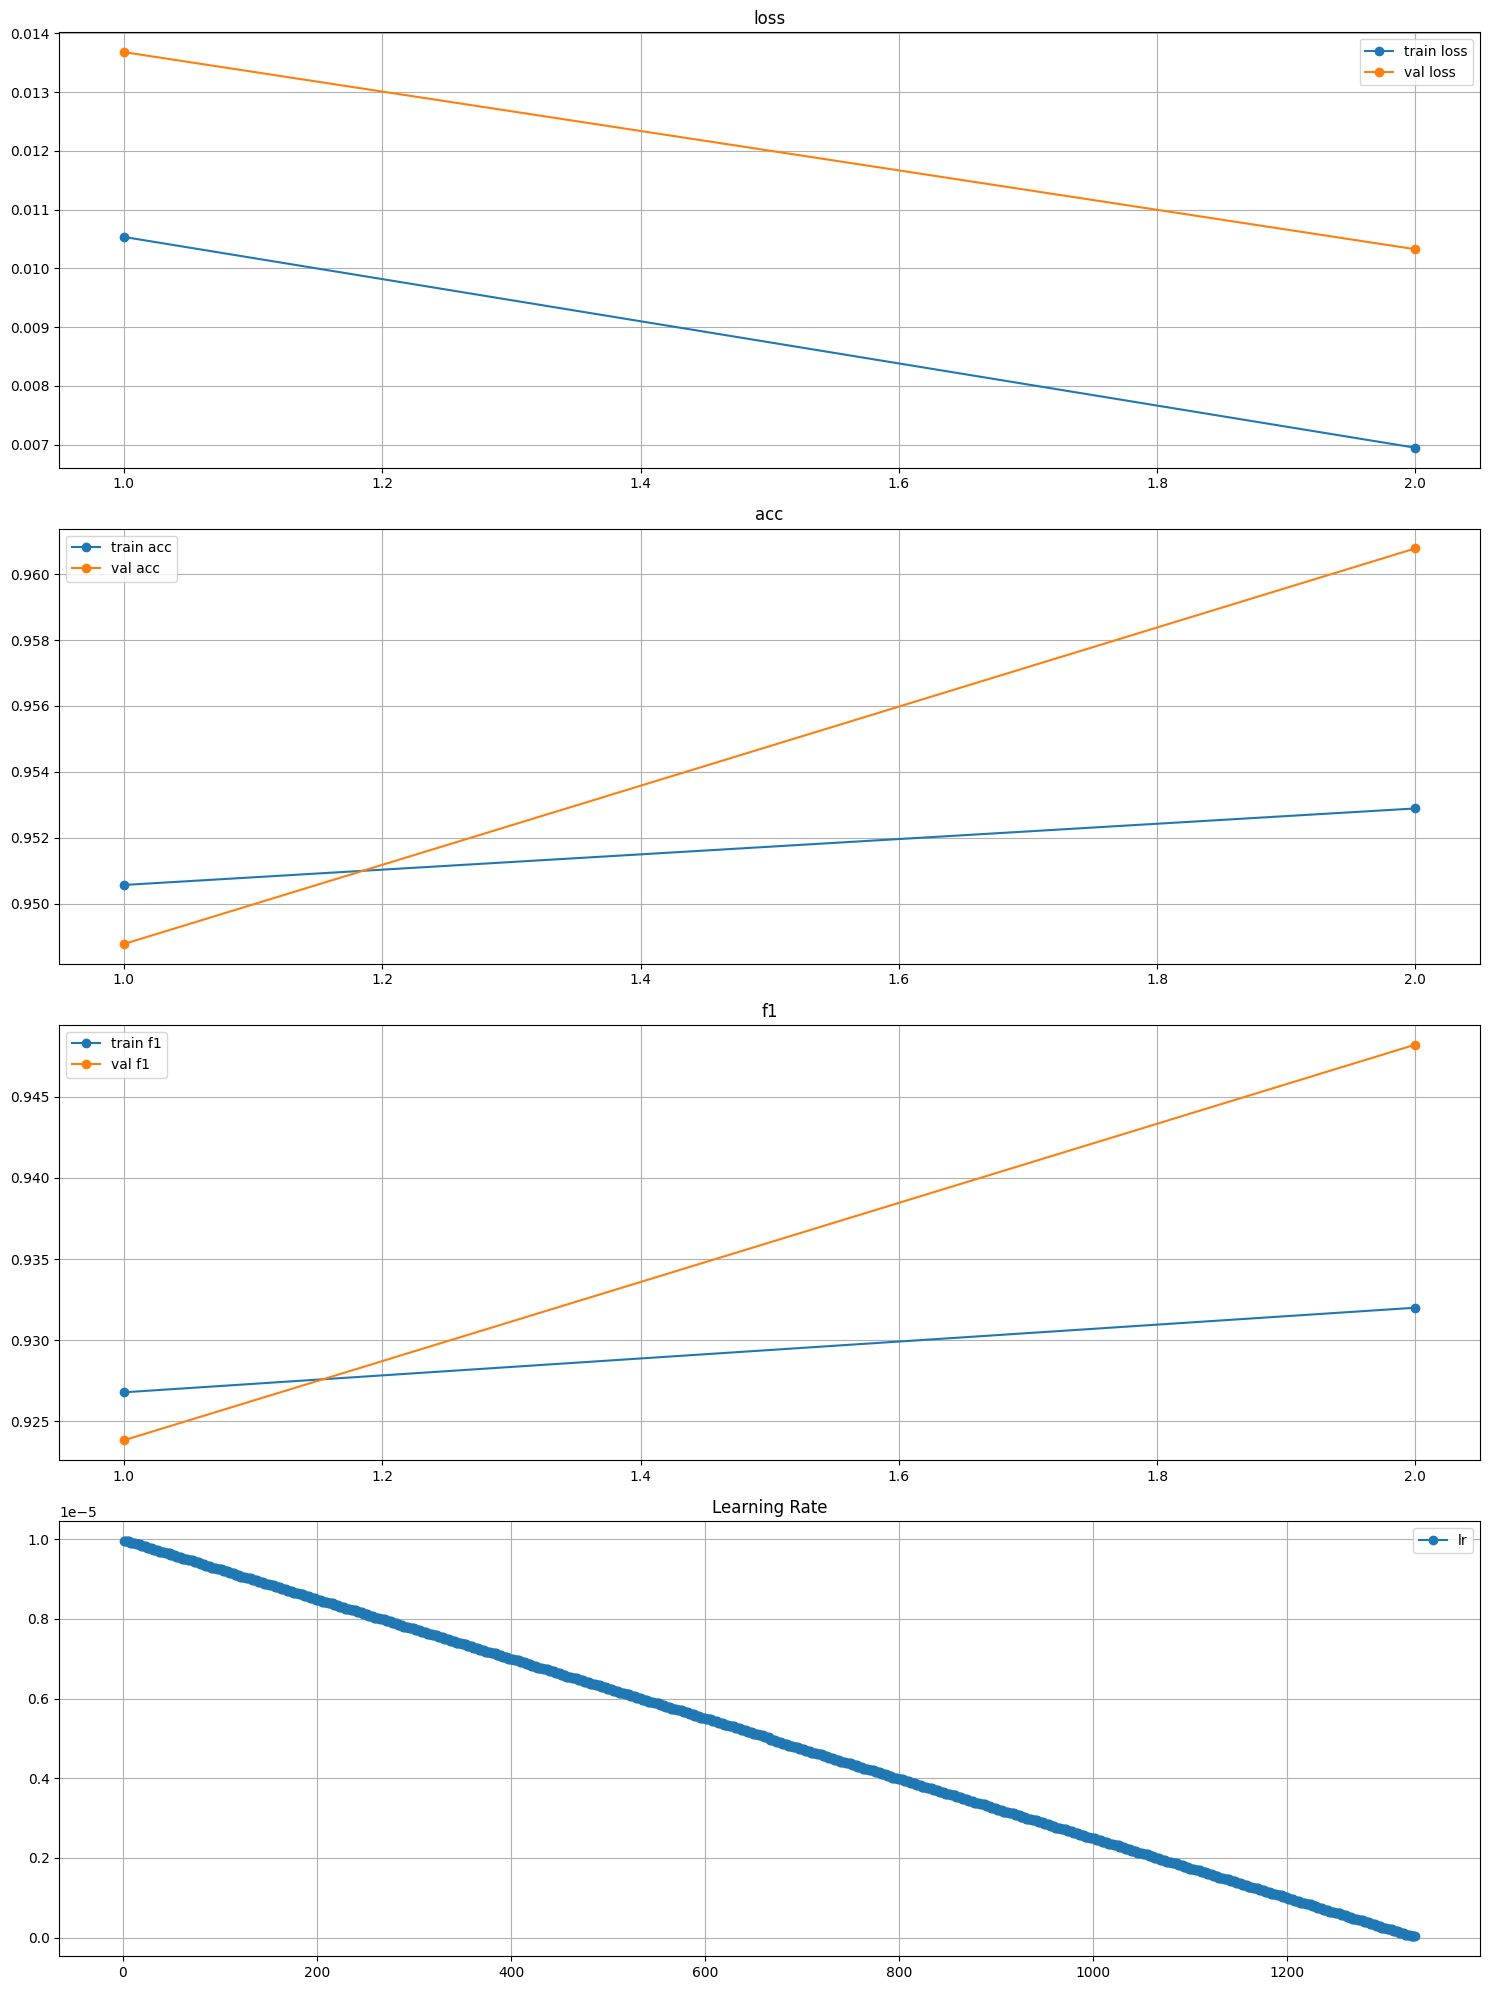

In [10]:
# モデルとオプティマイザの初期化
checkpoint_path = hps.model_state  # 以前に保存したチェックポイントのパスを設定
model_name = hps.model_name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, optimizer, start_epoch, best_loss, best_acc, best_f1, best_precision, best_recall, past_epochs, new_epochs, total_epochs, checkpoint = initialize_model_and_optimizer(checkpoint_path, model_name, device)

# スケジューラの設定
num_training_steps = new_epochs * len(train_loader)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# クラスウェイトの計算
class_weights = hps.class_weights

# トレーニングの実行
%cd '/content/drive/MyDrive/成果物3/'
model, history = fit(
    dataloaders={'train': train_loader, 'val': dev_loader},
    model=model,
    optimizer=optimizer,
    past_epochs=past_epochs,  # 過去のトレーニング回数
    new_epochs=new_epochs,  # 新しいトレーニング回数
    batch_size=hps.batch_size,
    scheduler=scheduler,
    class_weights_tensor=torch.tensor(class_weights, device=device, dtype=torch.float32),
    start_epoch=start_epoch,
    checkpoint=checkpoint  # checkpointインスタンスを渡す
)


# 学習履歴のプロット
def history_plot(history, past_epochs, new_epochs):
    total_epochs = past_epochs + new_epochs  # 合計エポック数を計算
    fig, axs = plt.subplots(4, 1, figsize=(15, 20))

    metrics = ['loss', 'acc', 'f1']
    phases = ['train', 'val']

    for i, metric in enumerate(metrics):
        for phase in phases:
            axs[i].plot(range(1, total_epochs + 1), history[phase][metric], marker='o', label=f'{phase} {metric}')
        axs[i].set_title(metric)
        axs[i].legend()
        axs[i].grid()

    axs[3].plot(range(1, len(history['lr']) + 1), history['lr'], marker='o', label='lr')
    axs[3].set_title('Learning Rate')
    axs[3].legend()
    axs[3].grid()

    fig.tight_layout()
    plt.show()

# プロット関数の呼び出し
history_plot(history, past_epochs, new_epochs)


In [11]:
def inference(model, dataloader, device, class_weights_tensor):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    preds_labels_dict = {'preds': [], 'labels': []}

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs = batch
            labels = batch['labels']
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            labels = labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * input_ids.size(0)

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels)

            preds_labels_dict['preds'].extend(preds.cpu().numpy())
            preds_labels_dict['labels'].extend(labels.cpu().numpy())

    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)
    total_f1 = f1_score(preds_labels_dict['labels'], preds_labels_dict['preds'], average='weighted')
    precision = precision_score(preds_labels_dict['labels'], preds_labels_dict['preds'], average='weighted')
    recall = recall_score(preds_labels_dict['labels'], preds_labels_dict['preds'], average='weighted')

    print(f"Loss: {total_loss:.4f}, Acc: {total_acc:.4f}, F1: {total_f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    return {
        'accuracy': total_acc,
        'f1': total_f1,
        'precision': precision,
        'recall': recall,
    }

# テストデータでの推論
class_weights_tensor = torch.tensor(class_weights, device=device, dtype=torch.float32)
evaluation_metrics = inference(model, test_loader, device, class_weights_tensor)
print(evaluation_metrics)


100%|██████████| 745/745 [11:40<00:00,  1.06it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loss: 0.0105, Acc: 0.9599, F1: 0.9467, Precision: 0.9349, Recall: 0.9599
{'accuracy': tensor(0.9599, device='cuda:0', dtype=torch.float64), 'f1': 0.9467050055493429, 'precision': 0.9348711957794406, 'recall': 0.9599462591317491}


In [12]:
# モデルの重みをロードする関数
def load_model_weights(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

# 推測用の関数
def predict(model, dataloader, device):
    model.eval()
    preds = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            inputs = batch
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, batch_preds = torch.max(outputs, 1)
            preds.extend(batch_preds.cpu().numpy())

    return preds

# モデルの重みをロード
checkpoint_path = '/content/drive/MyDrive/成果物3/'+hps.model_state
model = BertLstmCnnModel(model_name=hps.model_name)
model = load_model_weights(model, checkpoint_path, device)
model.to(device)
tokenizer = BertTokenizer.from_pretrained(hps.model_name)
# 新たな文章をトークン化する関数
def predict_tokenize_function(batch):
    tokenized_batch = tokenizer(batch['歌い出し'], padding='max_length', truncation=True, max_length=256)
    return tokenized_batch

# 新たなデータを読み込んでトークン化
dfp = pd.read_csv('artist_combined.csv', encoding='shift_jis')
dfp['歌い出し'] = dfp['歌い出し'].str.replace('\\U3000', '')
df_pre = Dataset.from_pandas(dfp['歌い出し'].to_frame())
predict_tokenized_dataset = df_pre.map(predict_tokenize_function, batched=True)

def collate_fn(batch):
    """バッチを辞書として返すcollate関数"""
    input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
    attention_mask = torch.stack([torch.tensor(item['attention_mask']) for item in batch])
    # labelsは予測時には不要なので除外
    return {'input_ids': input_ids, 'attention_mask': attention_mask}

# DataLoaderを作成
predict_loader = DataLoader(predict_tokenized_dataset,
                          batch_size=hps.batch_size,
                          shuffle=False,
                          collate_fn=collate_fn) # collate_fnを指定

# 推測を実行
predictions = predict(model, predict_loader, device)

# 推測結果をデータフレームに保存
dfe = pd.DataFrame()
dfe['Anger'] = predictions
dfe.to_csv(hps.emotion + 'predictions.csv', index=False, encoding='utf-8-sig')
print("Predictions saved to 'predictions.csv'")


<ipython-input-12-6900aedcce9c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/成果物3/Angerbert+_norm/tohoku-nlp_bert-base-japanese-v3__epoch001__20250110_1151.pth'